In [1]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

import shap

%config InlineBackend.figure_format = 'retina'

In [2]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [13]:
df = pd.read_csv('../../../../Data/cover_type_engineered.csv')

In [14]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
df = df.loc[(df['Cover_Type'] == 1) | (df['Cover_Type'] == 2)]

X = df.drop(columns=['Cover_Type', 'Aspect_Sector', 'rolling_mean_elevation', 'exp_elevation'])
y_train = df['Cover_Type'] - 1

In [15]:
y_train.unique()

array([0, 1])

In [16]:
X = X[['Wilderness_Area3',
 'Hillshade_Noon',
 'elevation_bin',
 'Euclidian_Distance',
 'Horizontal_Distance_To_Roadways',
 'Wilderness_Area4',
 'Vertical_Distance_To_Hydrology',
 'Elevation',
 'sqrt_elevation',
 'subalpine',
 'Wilderness_Area2',
 'Aspect_Sector_NW',
 'Diff_Noon_3pm',
 'igneous_and_metamorphic',
 'montane',
 'alpine',
 'Wilderness_Area1',
 'log_elevation',
 'reciprocal_elevation',
 'Horizontal_Distance_To_Fire_Points',
 'elevation_squared',
 'montane_and_subalpine',
 'elevation_cubed',
 'glacial',
 'lower_montane',
 'Id',
 'Hillshade_9am',
 'Horizontal_Distance_To_Hydrology']]

In [10]:
X = X.loc[:, [col for col in X if not col.startswith('Soil_Type')]]

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X)

In [12]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the estimator
estimator = XGBClassifier(tree_method="hist")

# Define hyperparameters for tuning
hyperparameters = {
    "n_estimators": stats.randint(50, 150),  # Increased range
    "learning_rate": stats.uniform(0.05, 0.1),  # Adjusted range
    "colsample_bytree": stats.uniform(0.6, 0.4),
    "colsample_bylevel": stats.uniform(0.6, 0.4),
    "colsample_bynode": stats.uniform(0.6, 0.4),
    "max_depth": stats.randint(15, 50),  # Increased range
    "subsample": stats.uniform(0.6, 0.4),
    "gamma": stats.uniform(0, 2),  # Adjusted range
    "reg_lambda": stats.uniform(0, 2),  # Adjusted range
    "reg_alpha": stats.uniform(0, 2),  # Adjusted range
}

# Define the RandomizedSearchCV parameters
random_search = RandomizedSearchCV(estimator, 
                                   param_distributions=hyperparameters, 
                                   scoring='accuracy',
                                   return_train_score=True,
                                   n_iter=100, 
                                   cv=5, 
                                   verbose=10, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)

    
    # Save results
    results_path = f"../../../tuning_results/tuning_xgb/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        
    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)
    
    # Save .ipynb
    copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))
    
    # Save Model
    file_name = f"xgb_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))
        

except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5; 1/100] START colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486
[CV 3/5; 1/100] END colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486;, score=(train=0.967, test=0.867) total time=   1.7s
[CV 3/5; 3/100] START colsample_bylevel=0.8698622915794797, colsample_bynode=0.8358050972455455, colsample_bytree=0.9407374120760028, gamma=1.2344214433606333, learning_rate=0.12893826035272427, max_depth=48, n_estimators=119, reg_alpha=0.7182373623860

[CV 5/5; 1/100] START colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486
[CV 5/5; 1/100] END colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486;, score=(train=0.966, test=0.871) total time=   1.9s
[CV 5/5; 3/100] START colsample_bylevel=0.8698622915794797, colsample_bynode=0.8358050972455455, colsample_bytree=0.9407374120760028, gamma=1.2344214433606333, learning_rate=0.12893826035272427, max_depth=48, n_estimators=119, reg_alpha=0.7182373623860179, reg_lambda=0.7731950504923899, subsample=0.901602246996472

[CV 1/5; 1/100] START colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486
[CV 1/5; 1/100] END colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486;, score=(train=0.968, test=0.870) total time=   1.8s
[CV 2/5; 3/100] START colsample_bylevel=0.8698622915794797, colsample_bynode=0.8358050972455455, colsample_bytree=0.9407374120760028, gamma=1.2344214433606333, learning_rate=0.12893826035272427, max_depth=48, n_estimators=119, reg_alpha=0.7182373623860179, reg_lambda=0.7731950504923899, subsample=0.901602246996472

[CV 3/5; 2/100] START colsample_bylevel=0.916303315554522, colsample_bynode=0.7841557047553714, colsample_bytree=0.6790932884496488, gamma=1.624963263742505, learning_rate=0.1305409547223012, max_depth=19, n_estimators=60, reg_alpha=1.9933382730917488, reg_lambda=1.9624594760486118, subsample=0.9180393308896448
[CV 3/5; 2/100] END colsample_bylevel=0.916303315554522, colsample_bynode=0.7841557047553714, colsample_bytree=0.6790932884496488, gamma=1.624963263742505, learning_rate=0.1305409547223012, max_depth=19, n_estimators=60, reg_alpha=1.9933382730917488, reg_lambda=1.9624594760486118, subsample=0.9180393308896448;, score=(train=0.902, test=0.839) total time=   1.4s
[CV 4/5; 2/100] START colsample_bylevel=0.916303315554522, colsample_bynode=0.7841557047553714, colsample_bytree=0.6790932884496488, gamma=1.624963263742505, learning_rate=0.1305409547223012, max_depth=19, n_estimators=60, reg_alpha=1.9933382730917488, reg_lambda=1.9624594760486118, subsample=0.9180393308896448
[CV 4/5; 2

[CV 2/5; 1/100] START colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486
[CV 2/5; 1/100] END colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486;, score=(train=0.967, test=0.875) total time=   2.0s
[CV 1/5; 4/100] START colsample_bylevel=0.7910562626843222, colsample_bynode=0.6785966881461476, colsample_bytree=0.8439104617523596, gamma=1.2876478552247448, learning_rate=0.0728313829290867, max_depth=21, n_estimators=147, reg_alpha=1.028044320831239, reg_lambda=0.5749269729070459, subsample=0.9582954600550617


[CV 4/5; 1/100] START colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486
[CV 4/5; 1/100] END colsample_bylevel=0.6987050434647845, colsample_bynode=0.6342897897674257, colsample_bytree=0.7623566621951416, gamma=0.7757438623948729, learning_rate=0.12756023972813532, max_depth=17, n_estimators=71, reg_alpha=0.36199882485643853, reg_lambda=0.7435030708958885, subsample=0.9909163904037486;, score=(train=0.967, test=0.874) total time=   1.9s
[CV 4/5; 3/100] START colsample_bylevel=0.8698622915794797, colsample_bynode=0.8358050972455455, colsample_bytree=0.9407374120760028, gamma=1.2344214433606333, learning_rate=0.12893826035272427, max_depth=48, n_estimators=119, reg_alpha=0.7182373623860179, reg_lambda=0.7731950504923899, subsample=0.901602246996472

[CV 2/5; 2/100] START colsample_bylevel=0.916303315554522, colsample_bynode=0.7841557047553714, colsample_bytree=0.6790932884496488, gamma=1.624963263742505, learning_rate=0.1305409547223012, max_depth=19, n_estimators=60, reg_alpha=1.9933382730917488, reg_lambda=1.9624594760486118, subsample=0.9180393308896448
[CV 2/5; 2/100] END colsample_bylevel=0.916303315554522, colsample_bynode=0.7841557047553714, colsample_bytree=0.6790932884496488, gamma=1.624963263742505, learning_rate=0.1305409547223012, max_depth=19, n_estimators=60, reg_alpha=1.9933382730917488, reg_lambda=1.9624594760486118, subsample=0.9180393308896448;, score=(train=0.901, test=0.851) total time=   1.4s
[CV 1/5; 3/100] START colsample_bylevel=0.8698622915794797, colsample_bynode=0.8358050972455455, colsample_bytree=0.9407374120760028, gamma=1.2344214433606333, learning_rate=0.12893826035272427, max_depth=48, n_estimators=119, reg_alpha=0.7182373623860179, reg_lambda=0.7731950504923899, subsample=0.9016022469964721
[CV 1/

KeyboardInterrupt: 

In [ ]:
cv_results.head()

In [ ]:
results_path = f"../../../tuning_results/tuning_xgb/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# CV Evaluation

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report

In [13]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
375       0.857844      0.030058         0.011297        0.002013   
335       0.791344      0.018278         0.009840        0.001456   
13        0.577260      0.059426         0.007659        0.002144   
122       1.339673      0.040008         0.018989        0.005420   
216       0.905037      0.038731         0.010906        0.000884   

    param_colsample_bylevel param_colsample_bynode param_colsample_bytree  \
375                0.882879                0.86533               0.923495   
335                0.977956               0.829263               0.805863   
13                 0.784259               0.868535               0.912593   
122                0.799118               0.961407               0.952211   
216                0.623738               0.929222               0.888954   

    param_gamma param_learning_rate param_max_depth  ... mean_test_score  \
375    0.737296            0.086235              31  ...        0.841204   
335    0.341566            0.148484              34  ...        0.840509   
13     0.269344            0.137177              47  ...        0.840509   
122    0.094862            0.142789              47  ...        0.840278   
216    0.351416            0.089103              26  ...        0.839583   

    std_test_score rank_test_score split0_train_score split1_train_score  \
375       0.009184               1           0.993056           0.990162   
335       0.006645               2           0.999421           0.997975   
13        0.011490               2           0.996238           0.995370   
122       0.009628               4           1.000000           1.000000   
216       0.006890               5           0.998264           0.997685   

     split2_train_score  split3_train_score  split4_train_score  \
375            0.993056            0.990451            0.991609   
335            0.999132            0.999132            0.998843   
13             0.997106            0.995660            0.996238   
122            1.000000            1.000000            1.000000   
216            0.998843            0.998264            0.998264   

     mean_train_score  std_train_score  
375          0.991667         0.001233  
335          0.998900         0.000498  
13           0.996123         0.000596  
122          1.000000         0.000000  
216          0.998264         0.000366  

[5 rows x 30 columns]

In [14]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

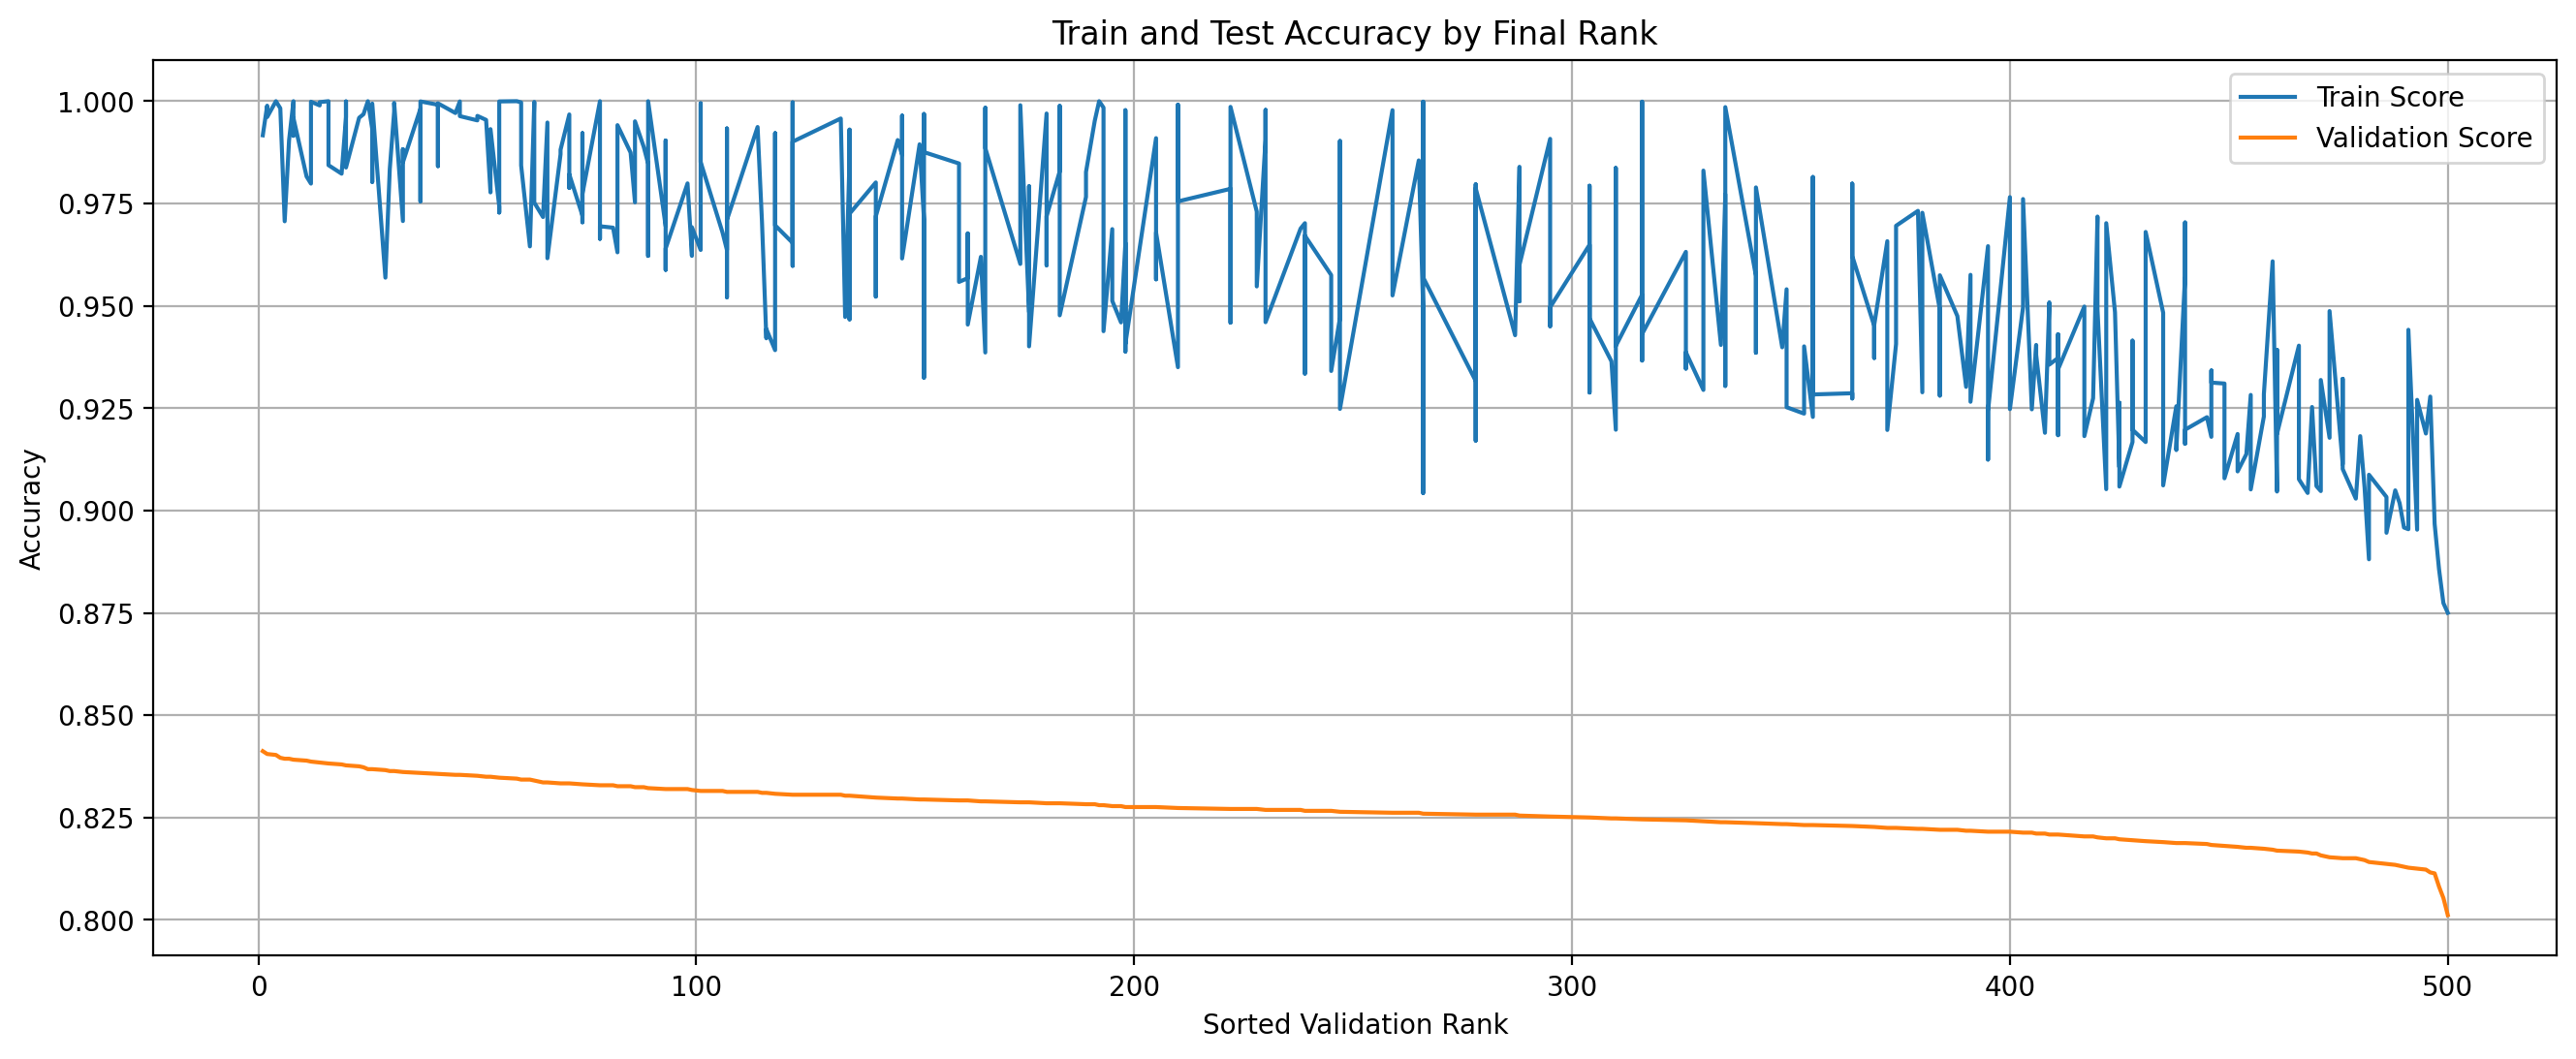

In [15]:
plt.figure(figsize=(16, 6))    

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Validation Score")

plt.grid()
plt.xlabel('Sorted Validation Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

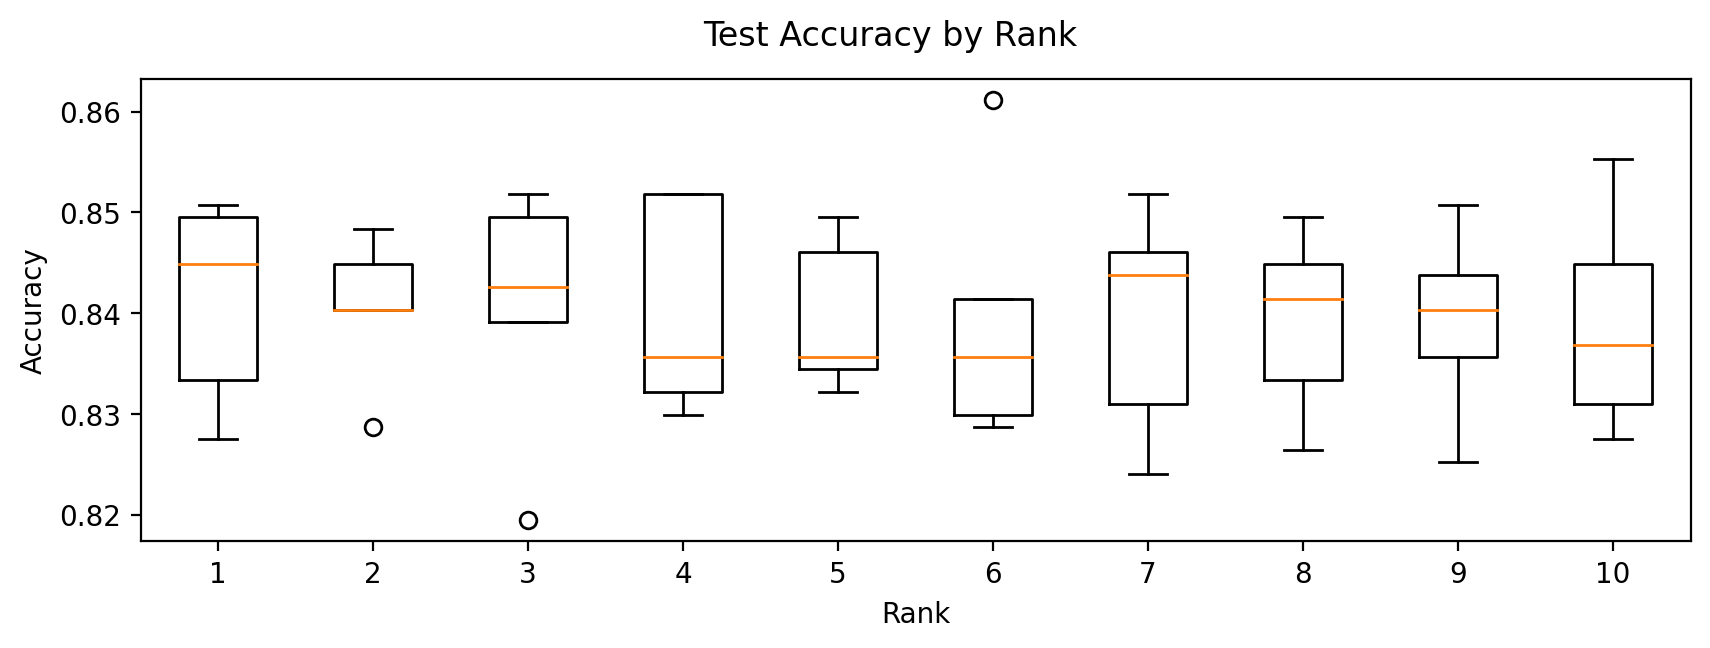

In [16]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

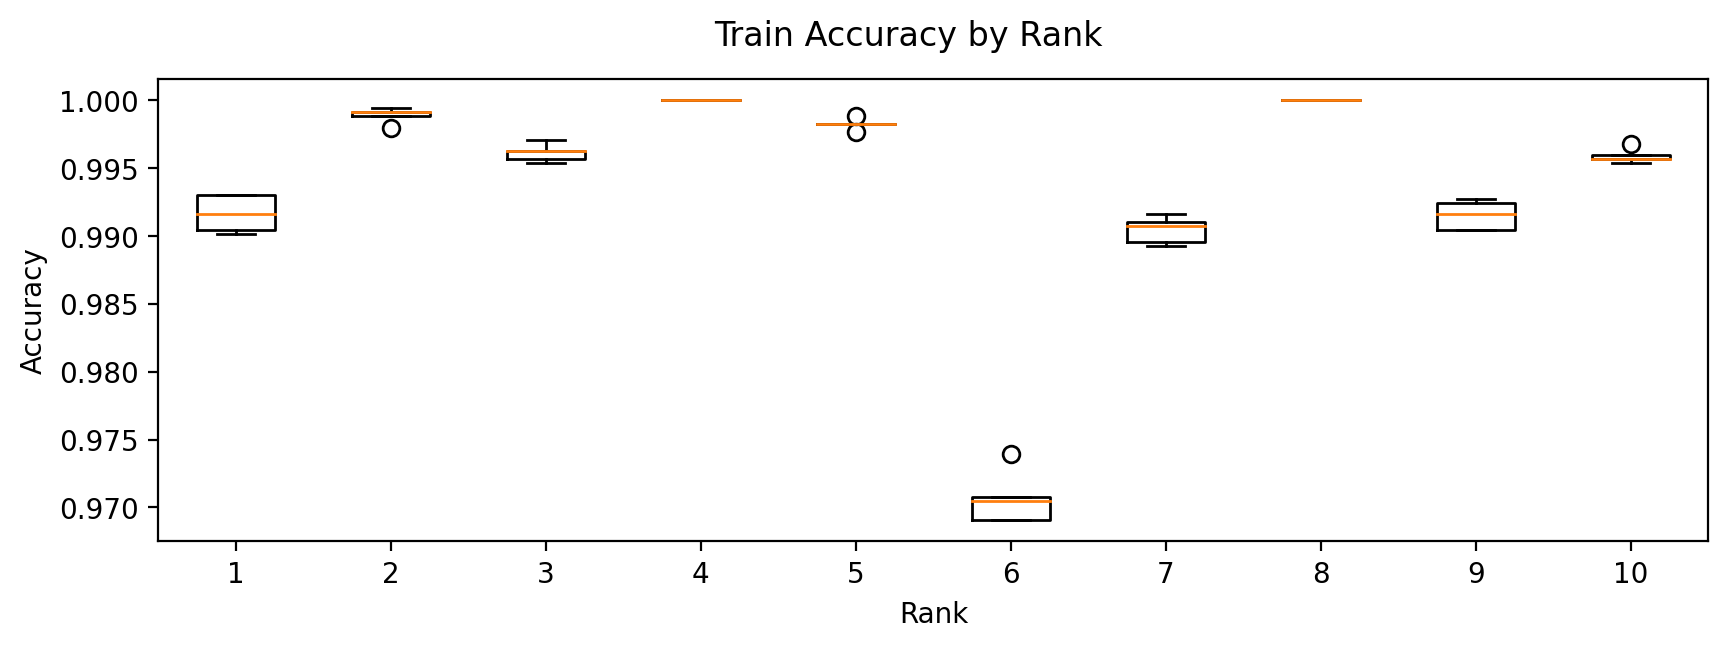

In [17]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [18]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [19]:
print(f"Mean Train Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Validation Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

Mean Train Accuracy = 0.99
Mean Validation Accuracy = 0.84


In [20]:
random_search = pickle.load(open(os.path.join(file_name, "rb"))
model = random_search.best_estimator_

#model = XGBClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
# y_test_prediction = model.predict(X_test)

In [21]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
# print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

Train set, Accuracy = 0.99


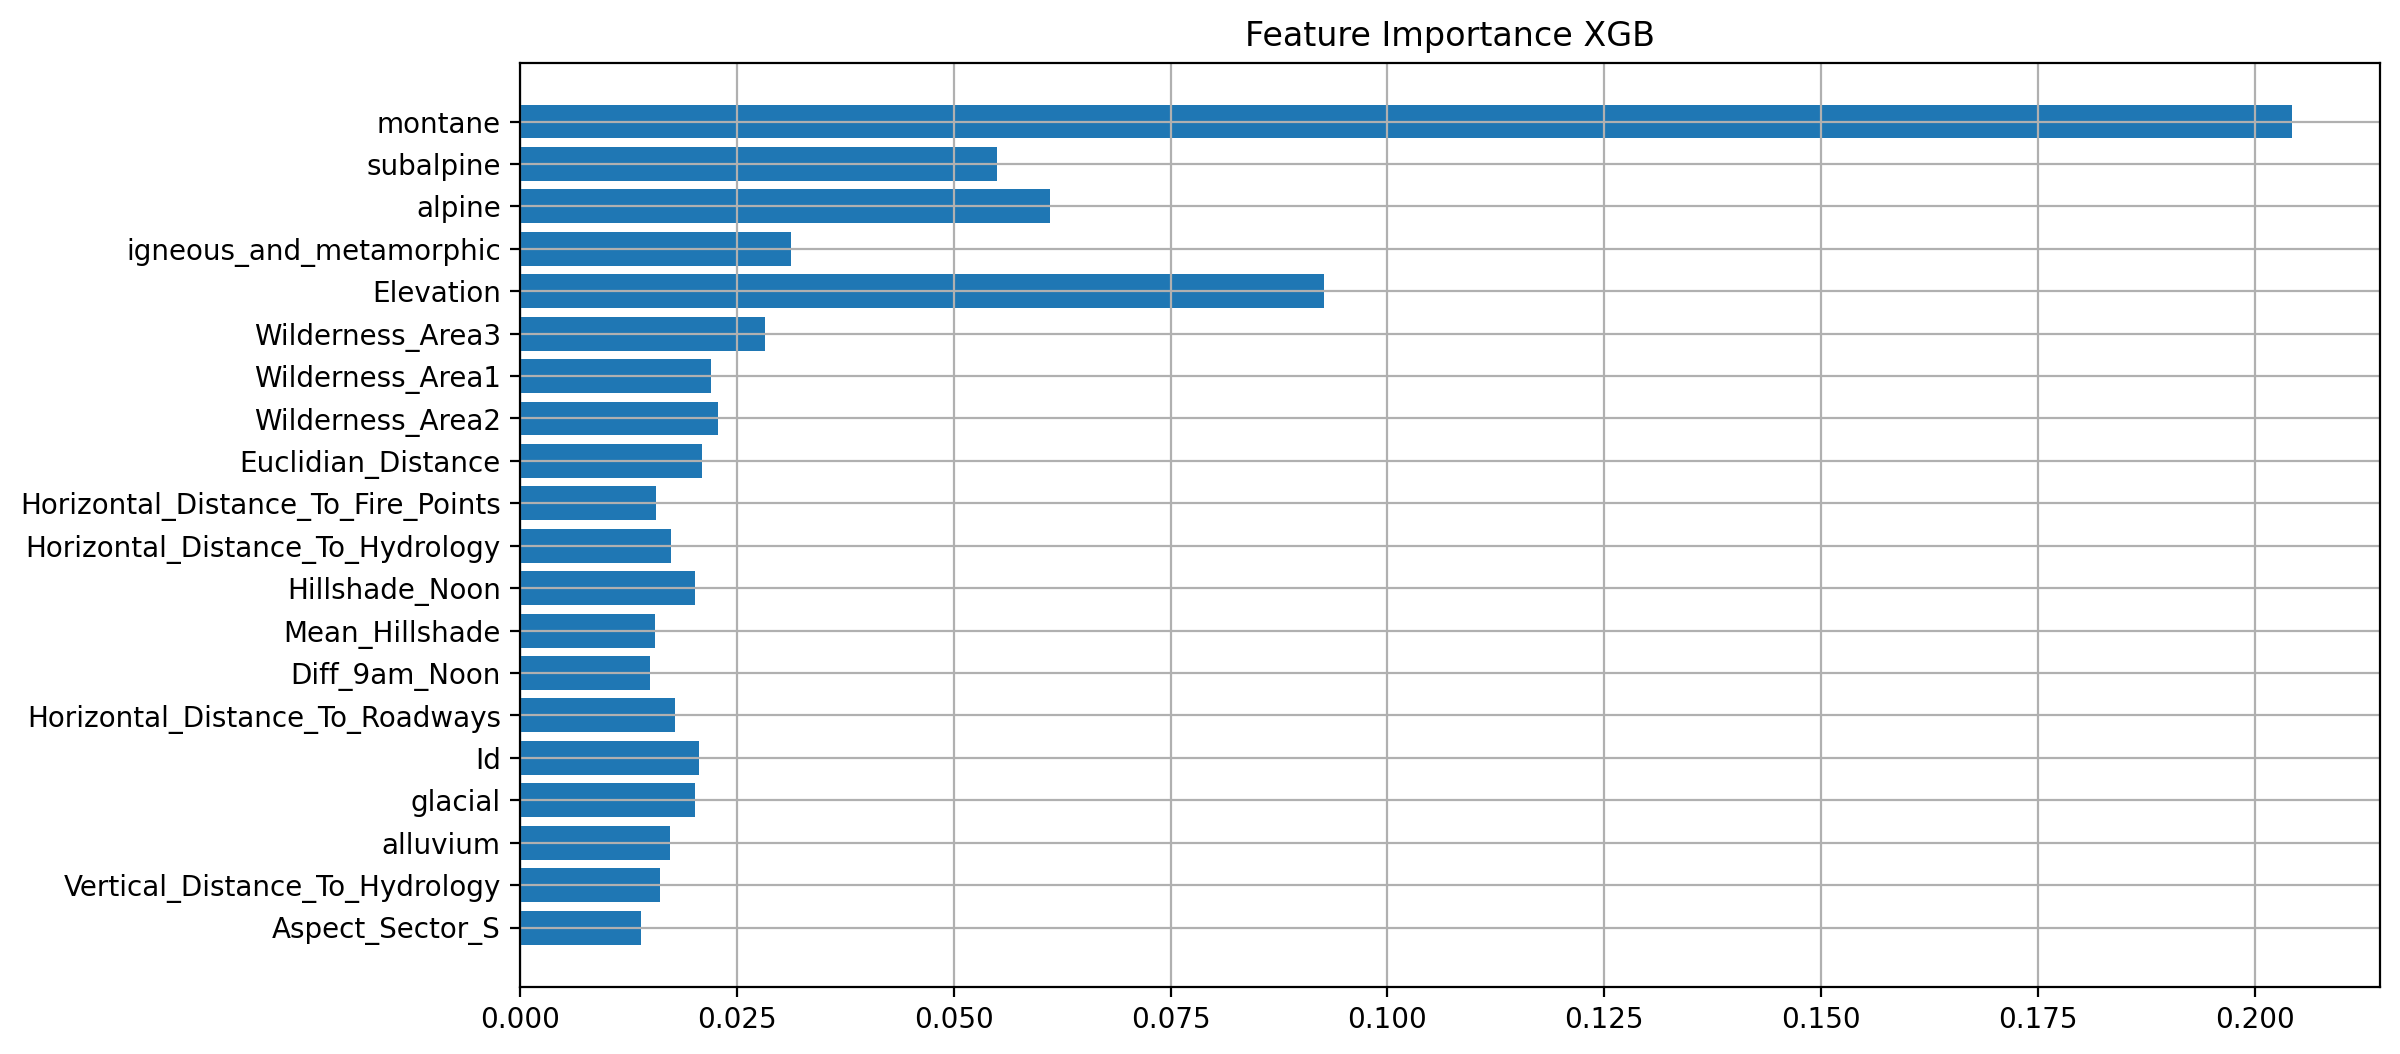

In [22]:
ind = np.argpartition(model.feature_importances_, -20)[-20:]

features = X.columns[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance XGB')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()

In the context of XGBoost, these scores are often computed based on the following:

- Weight: The number of times a feature appears in a tree across the ensemble of trees.
- Gain: The average gain of a feature when it is used in trees.
- Cover: The average coverage of a feature when it is used in trees.

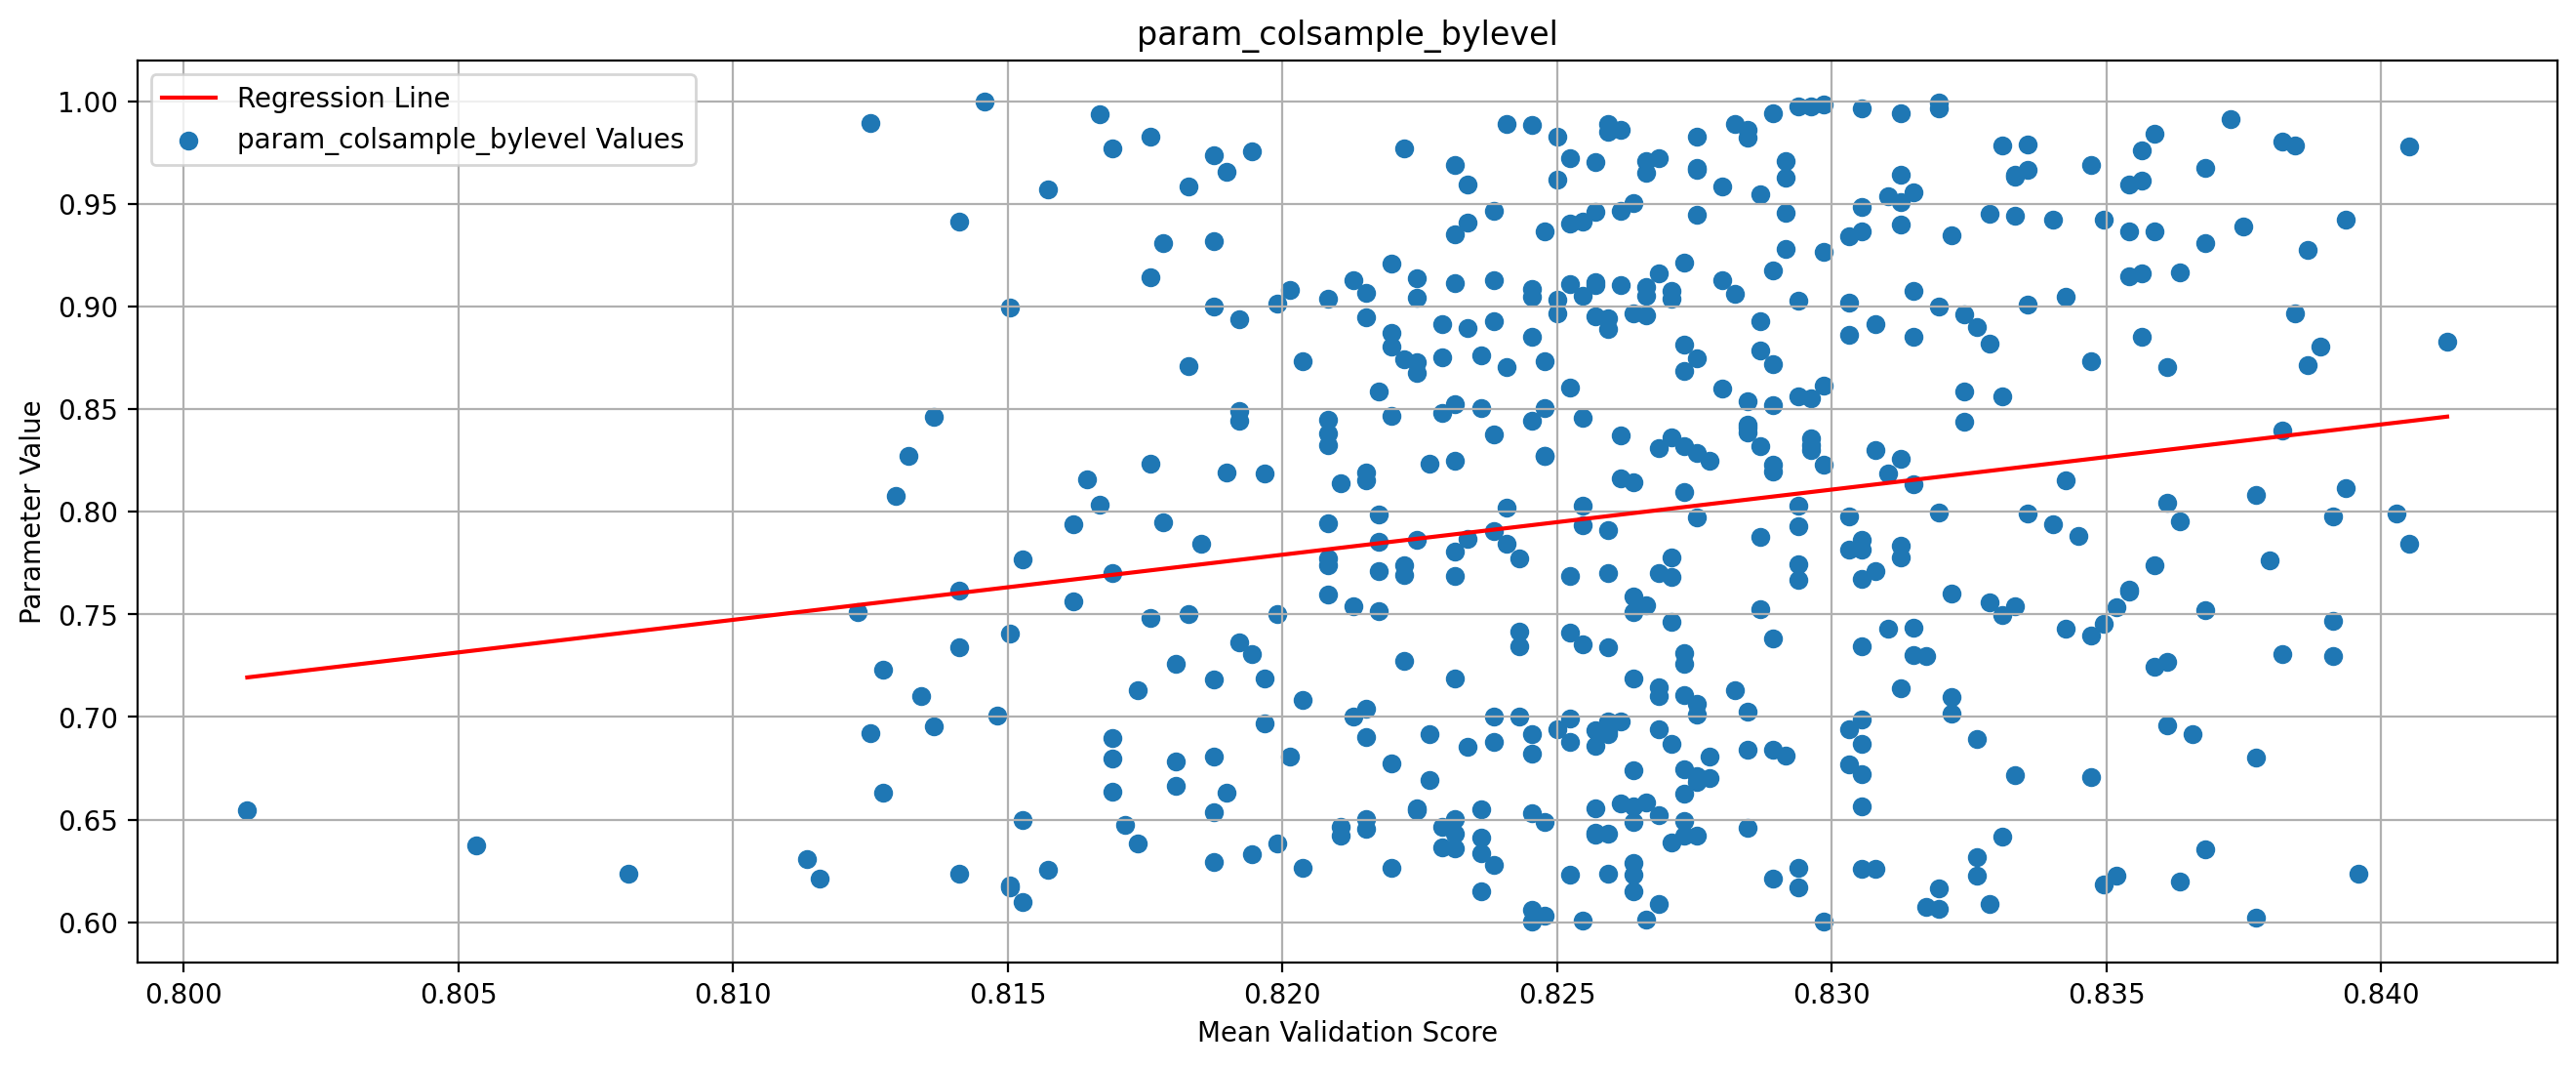

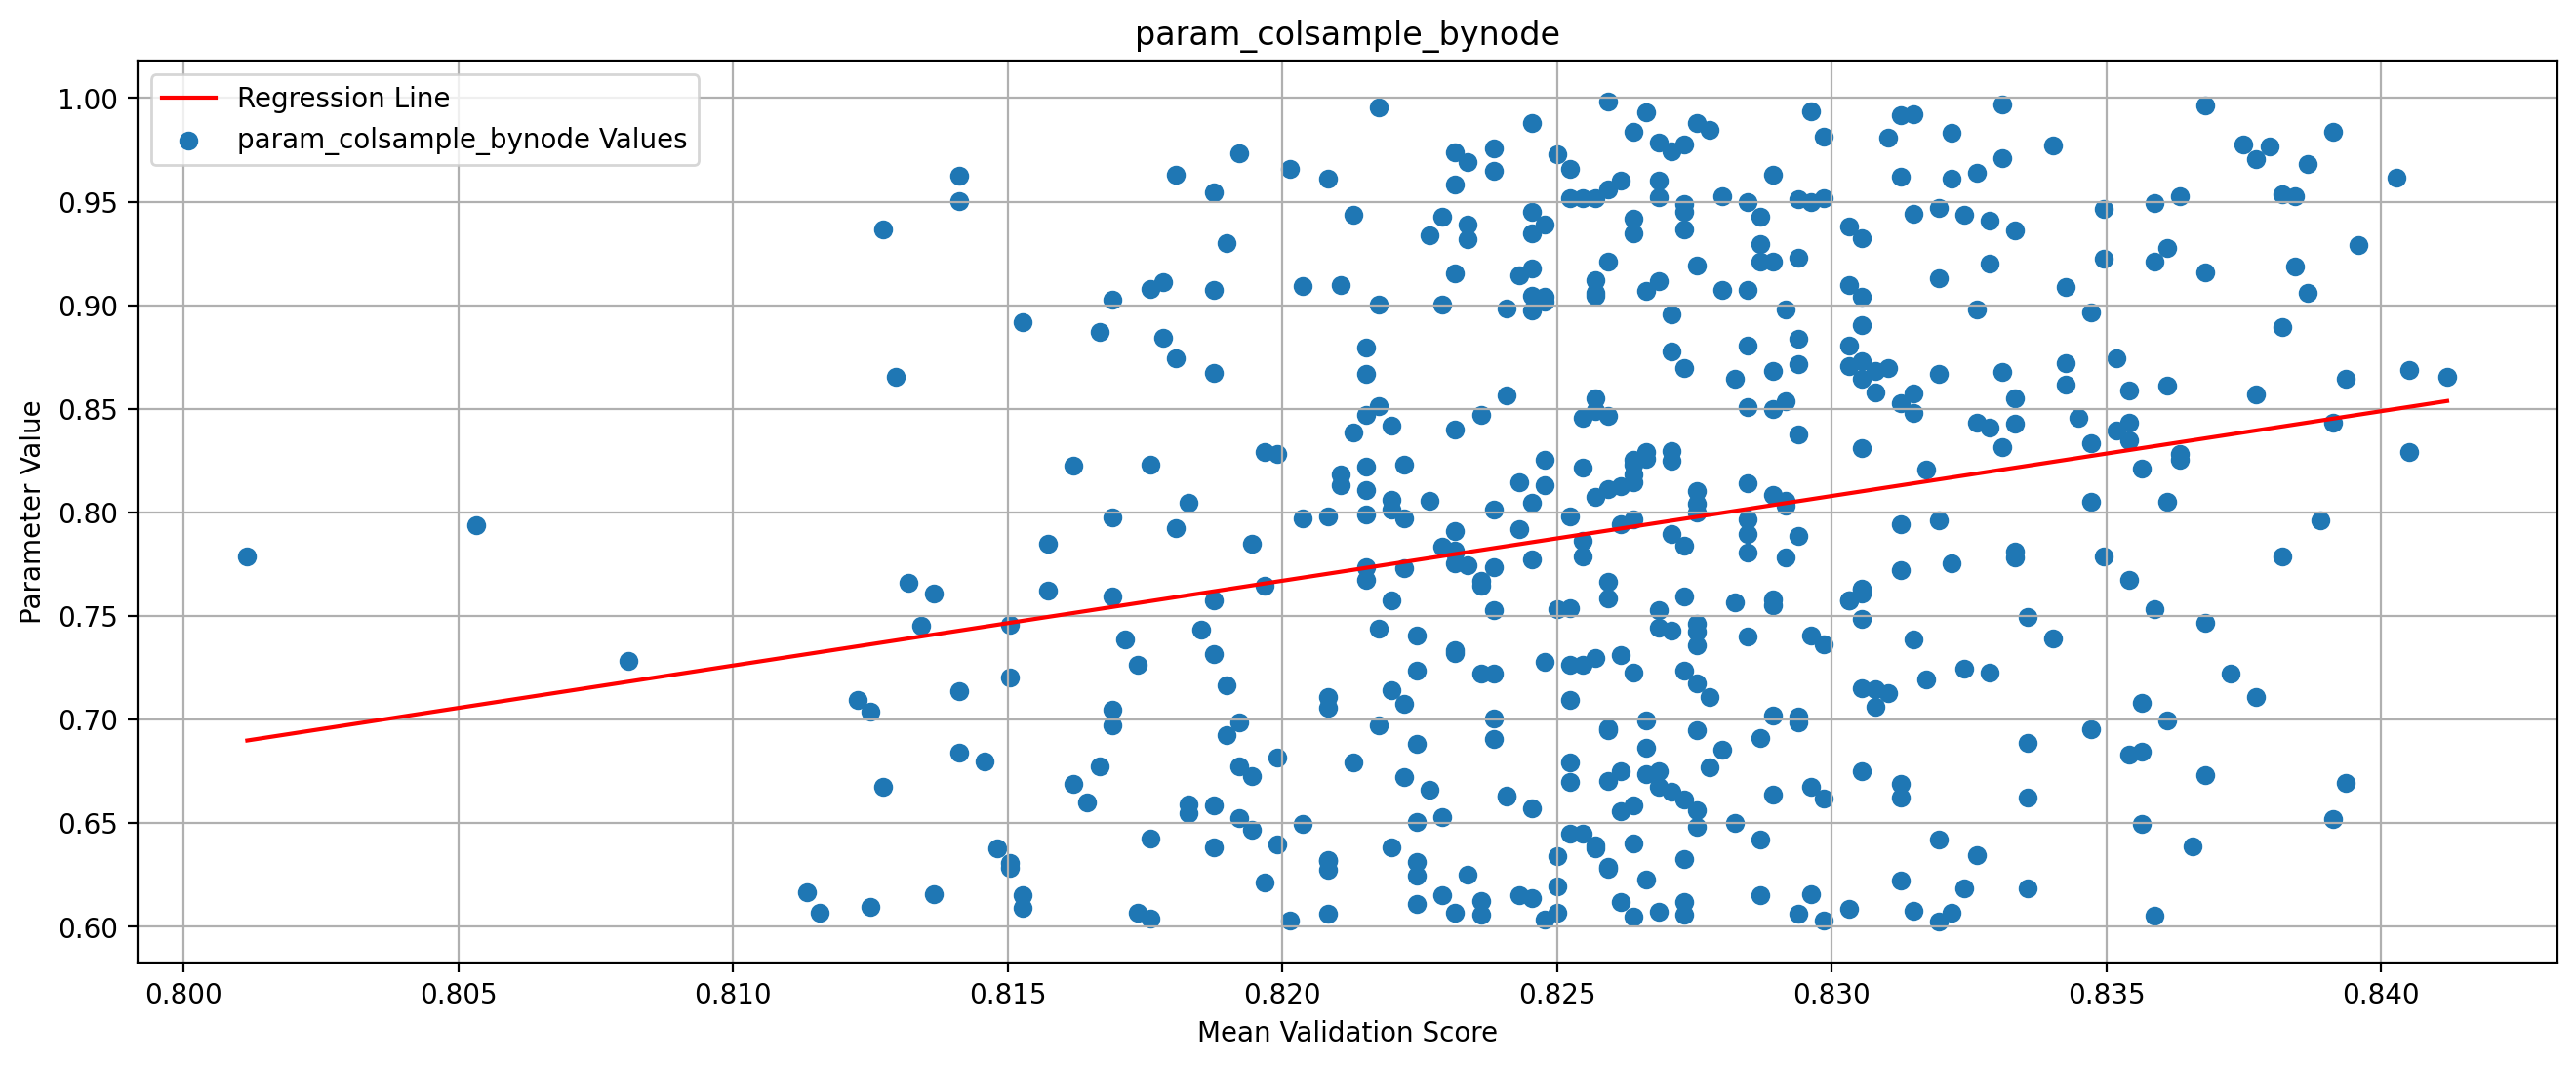

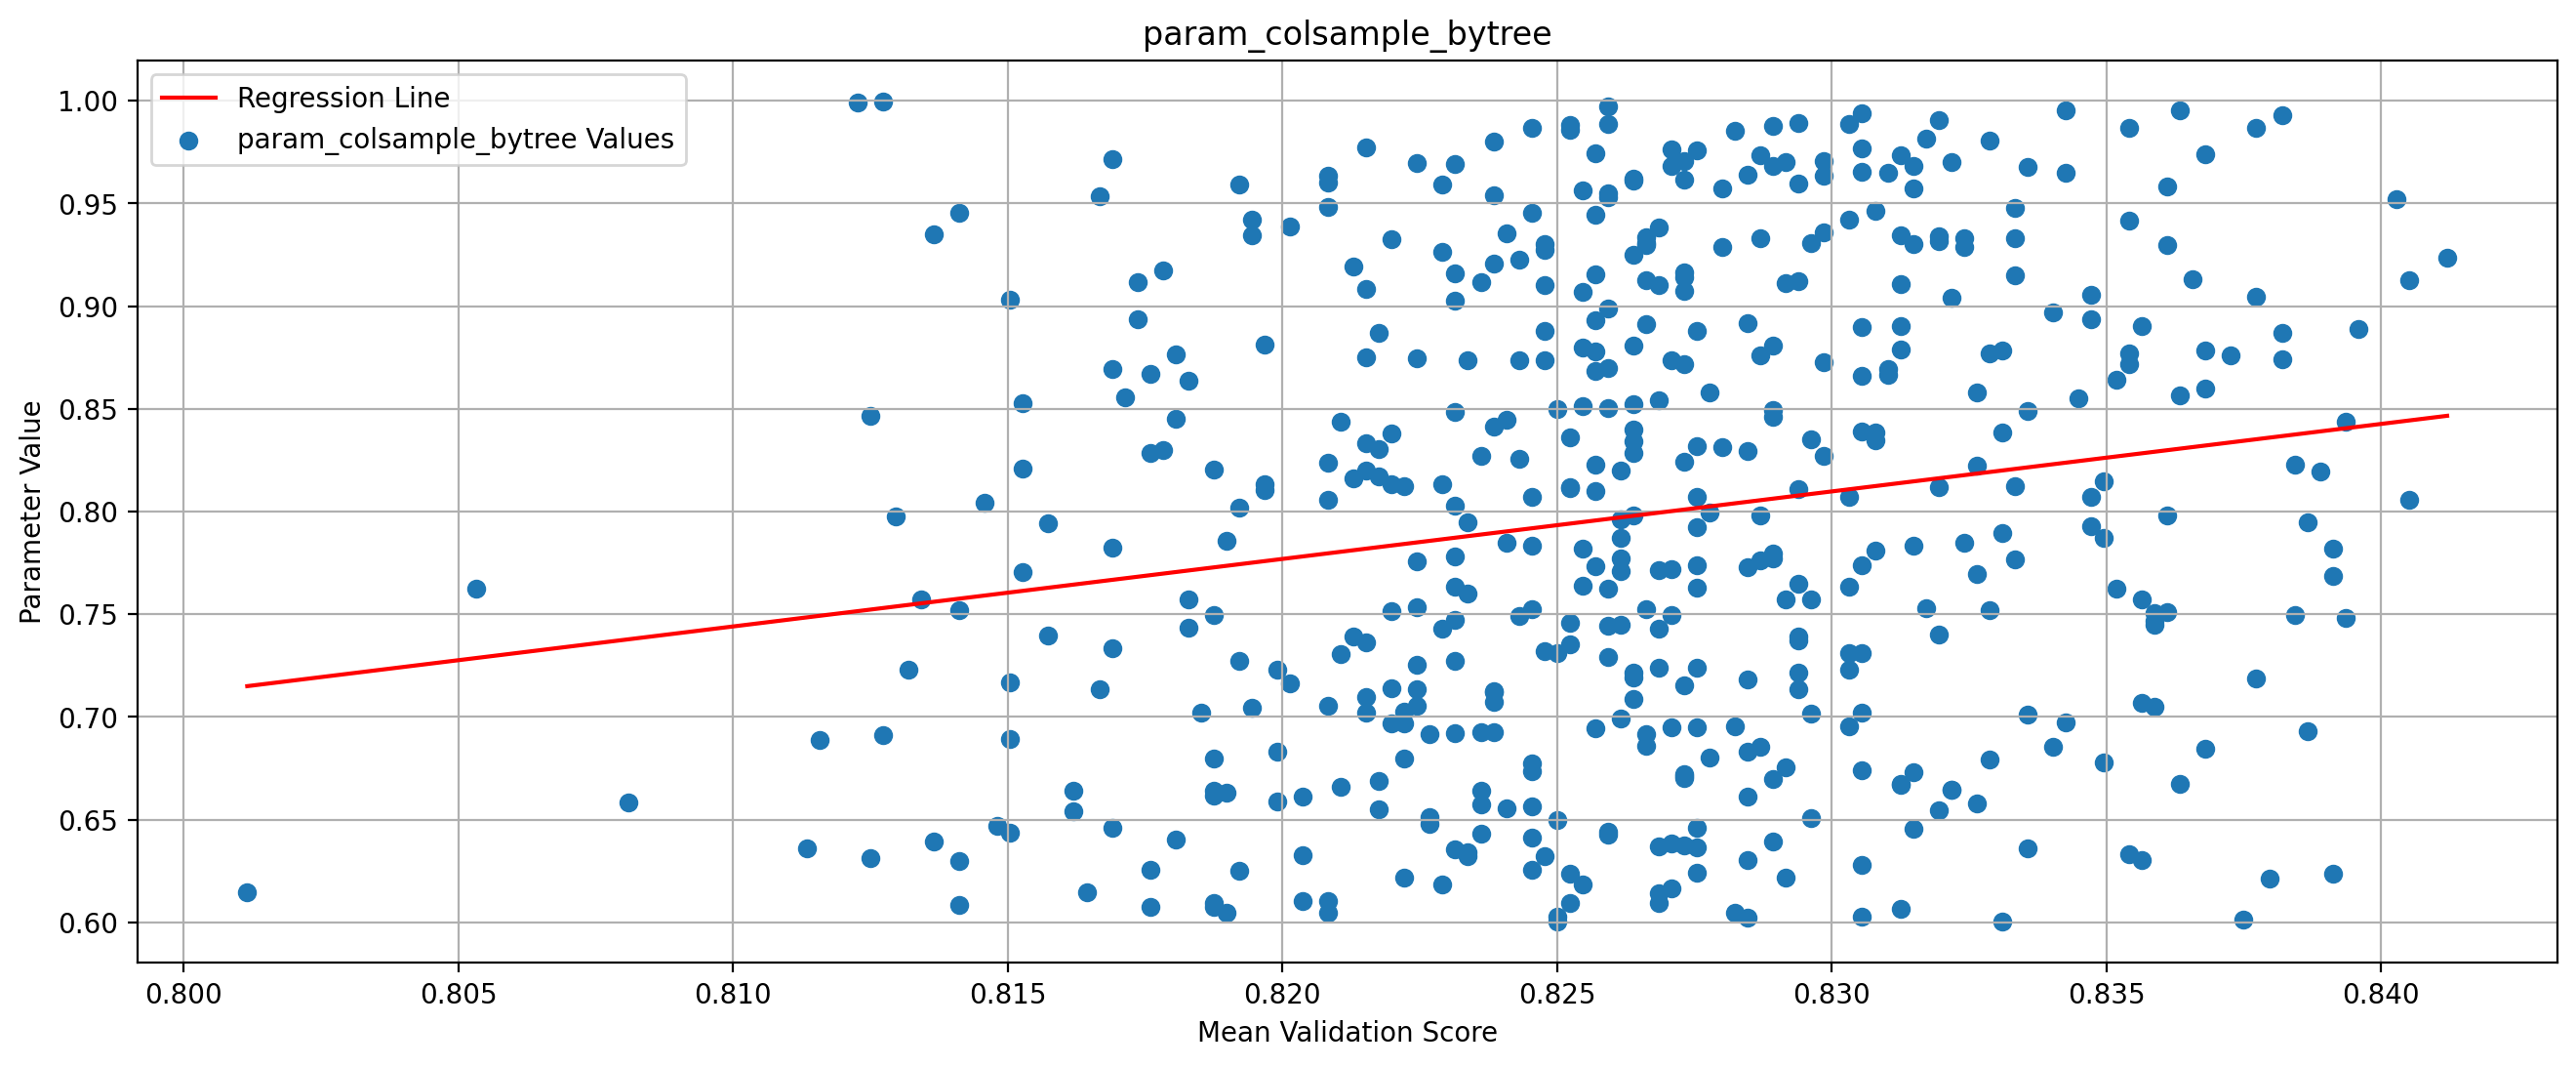

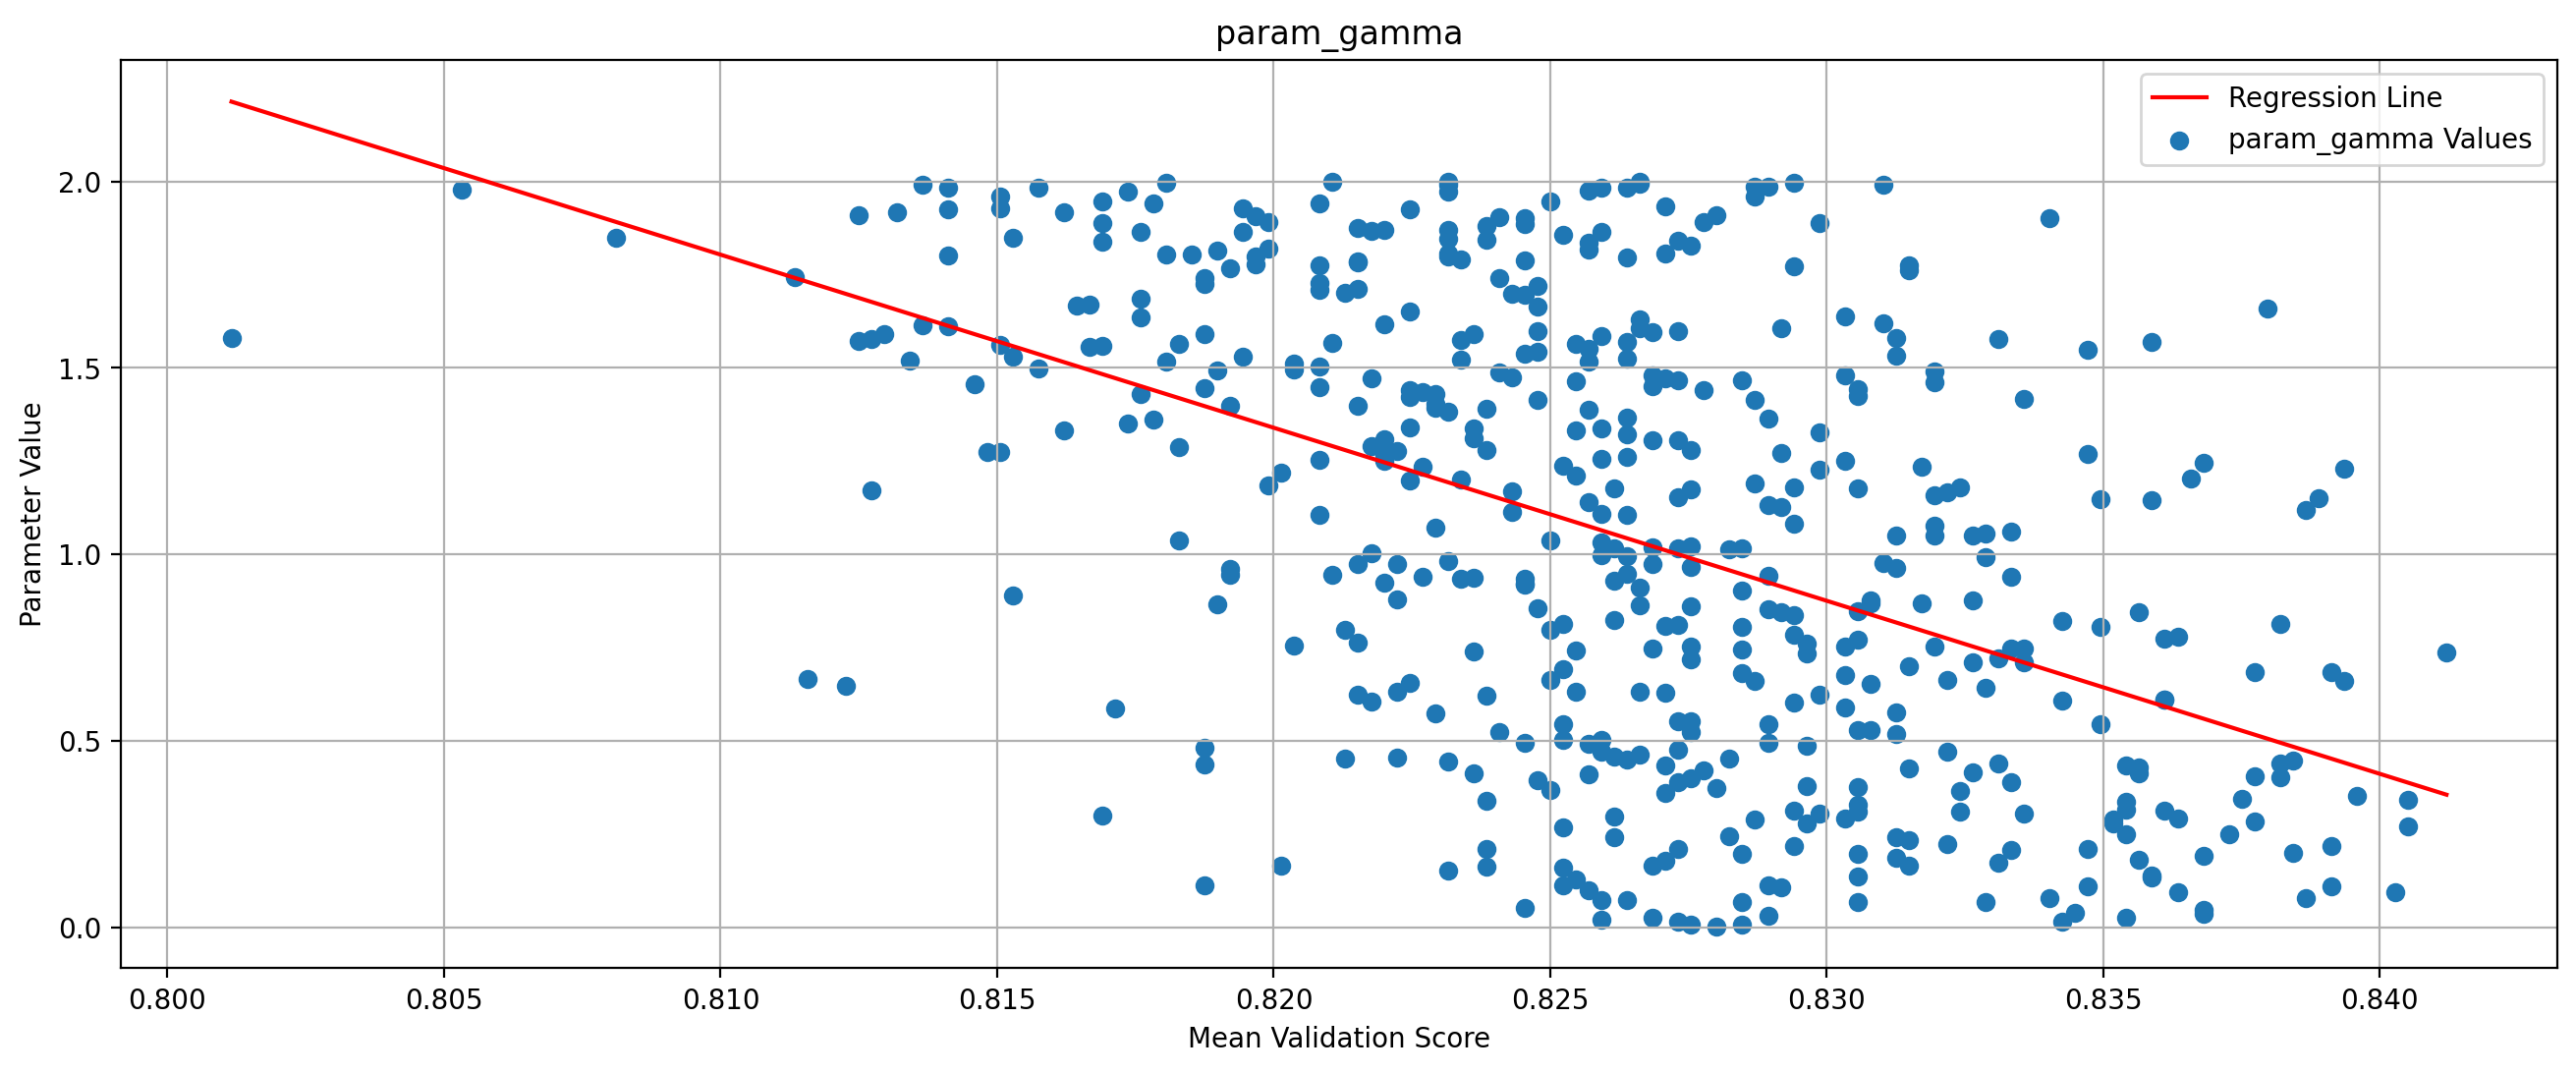

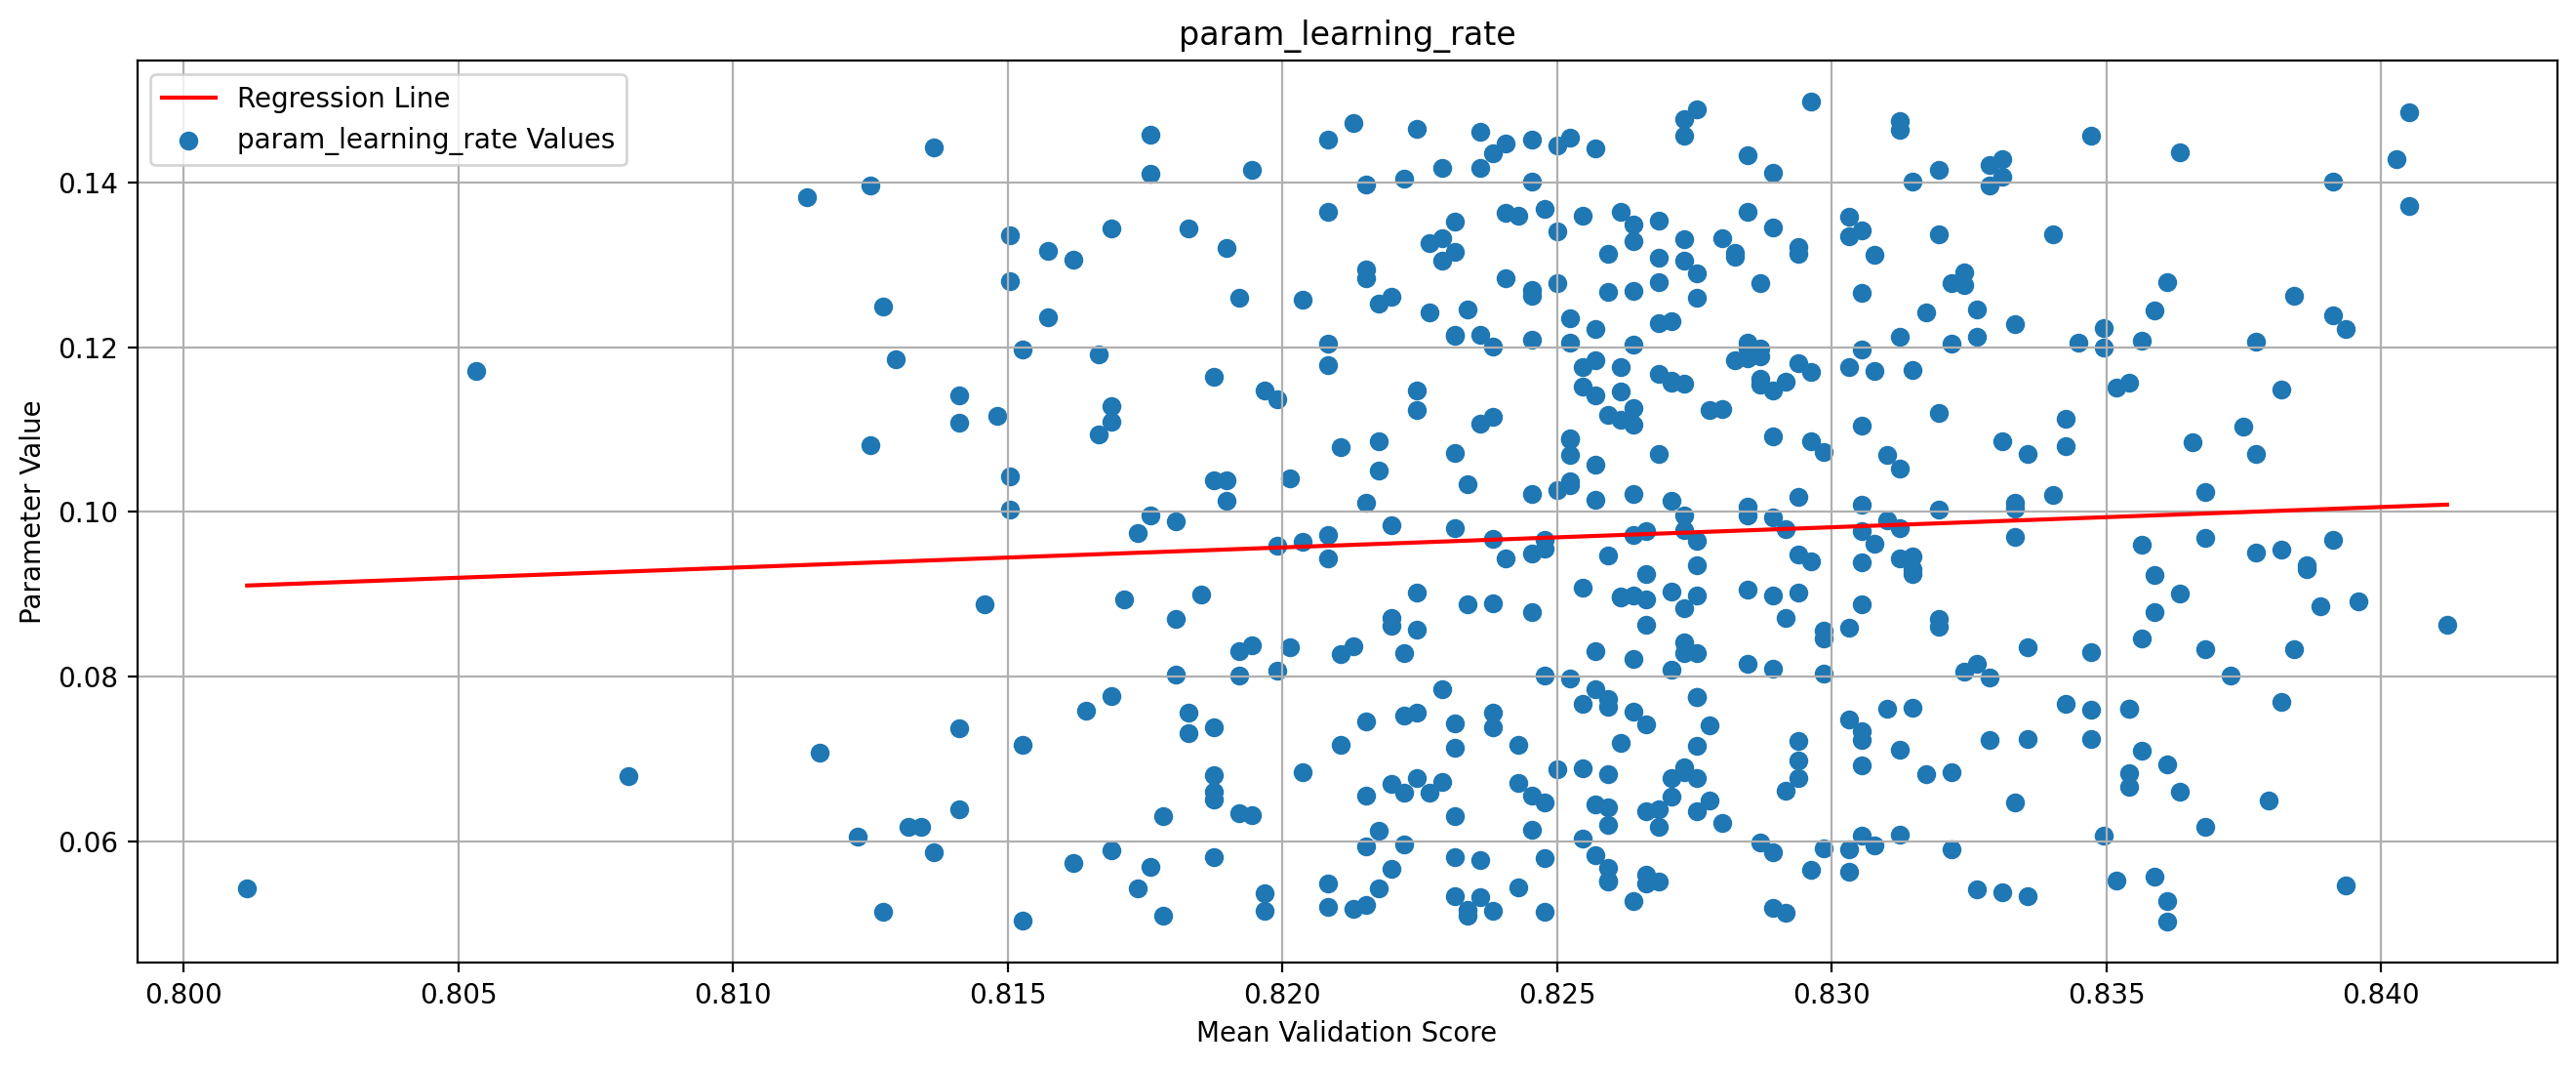

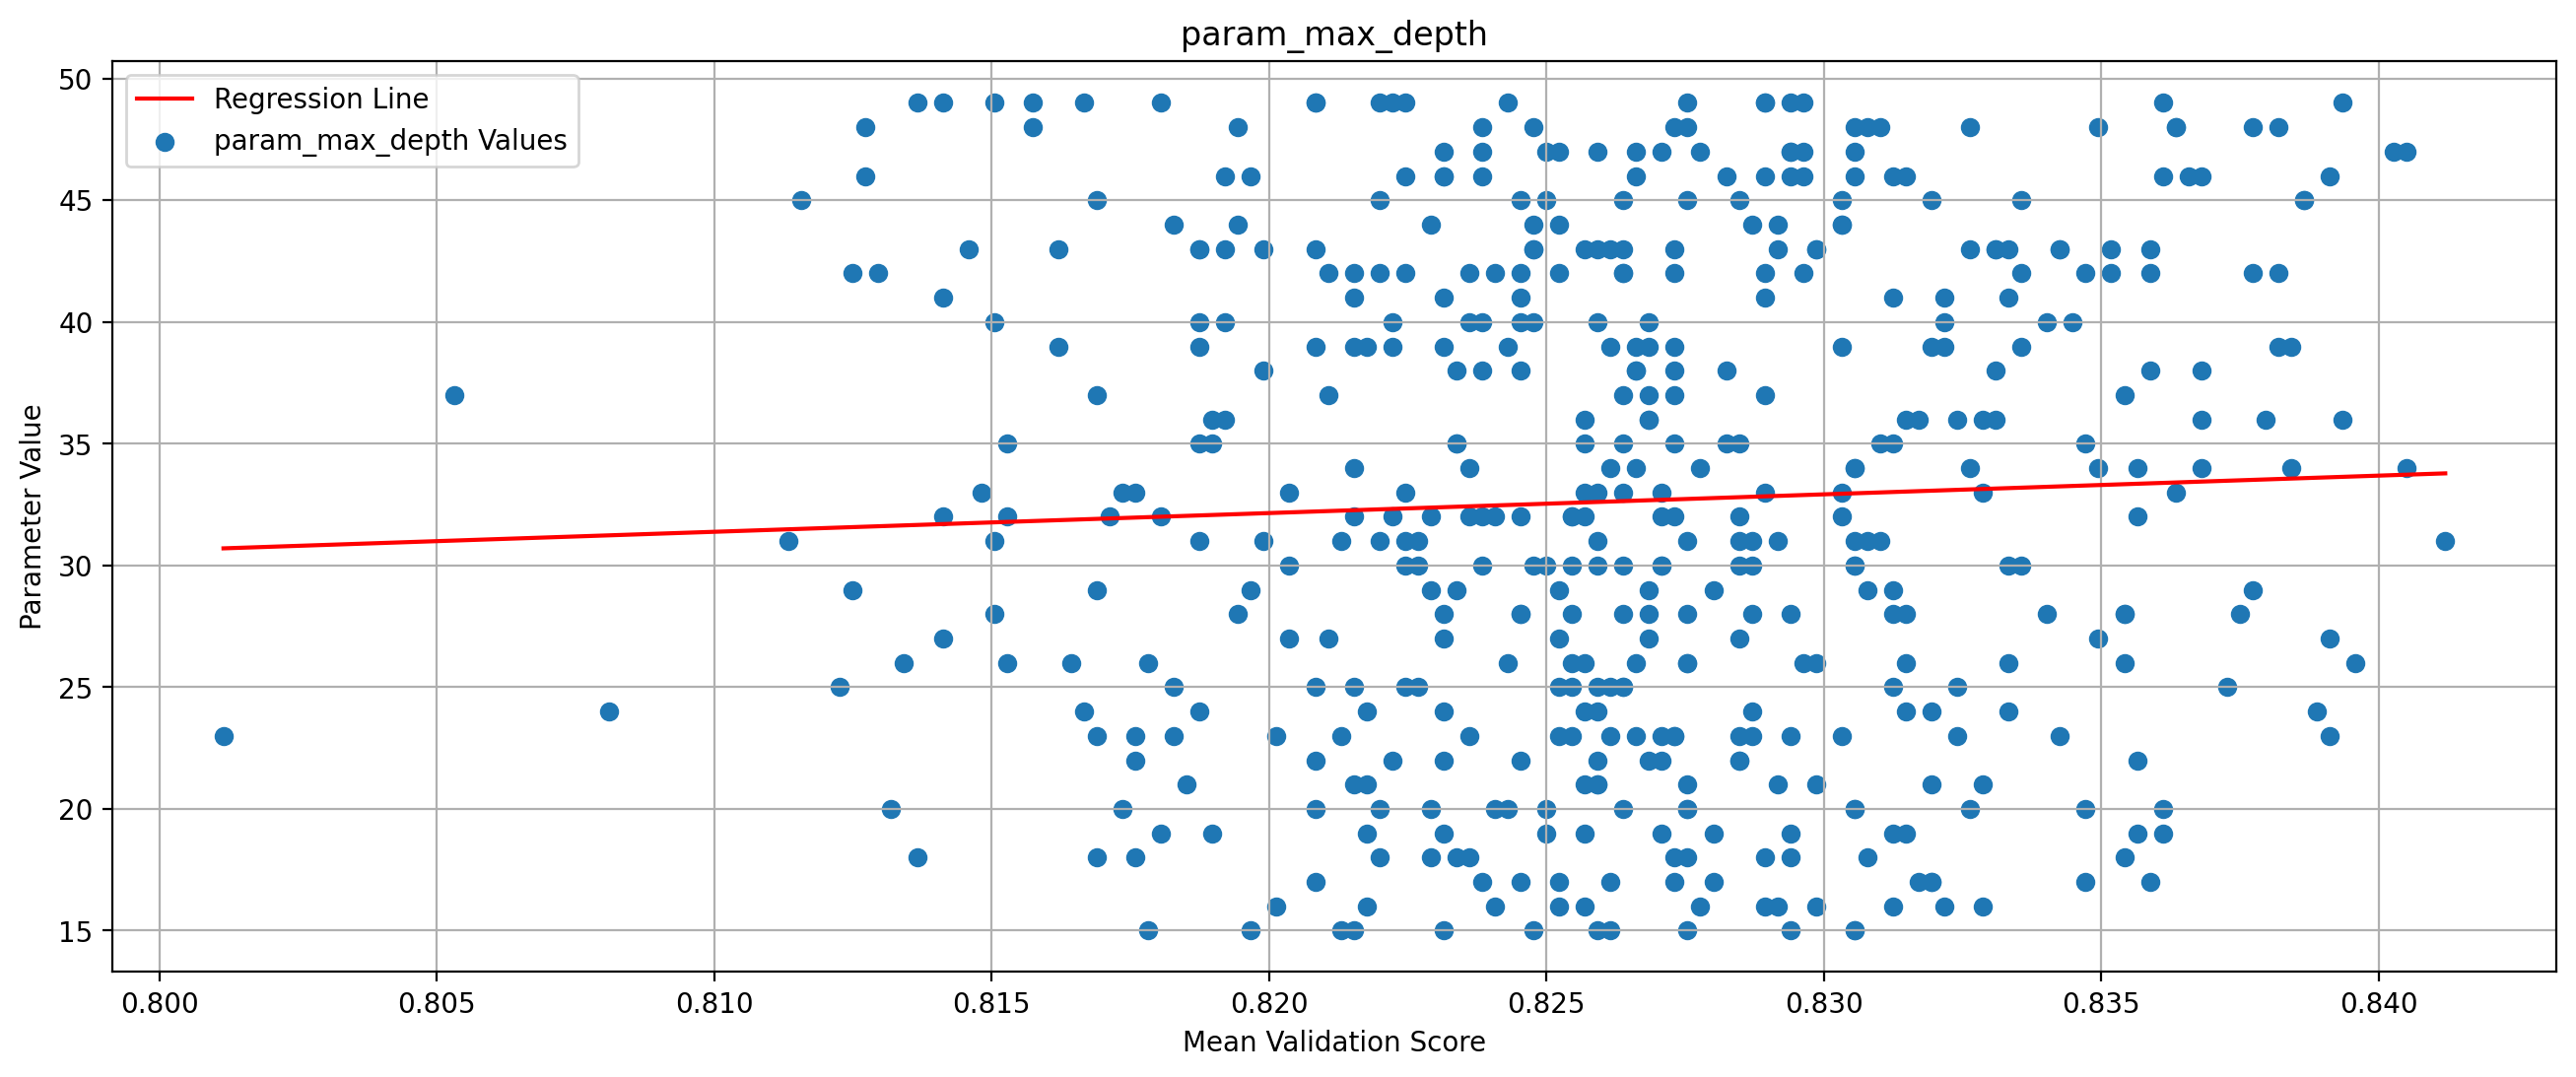

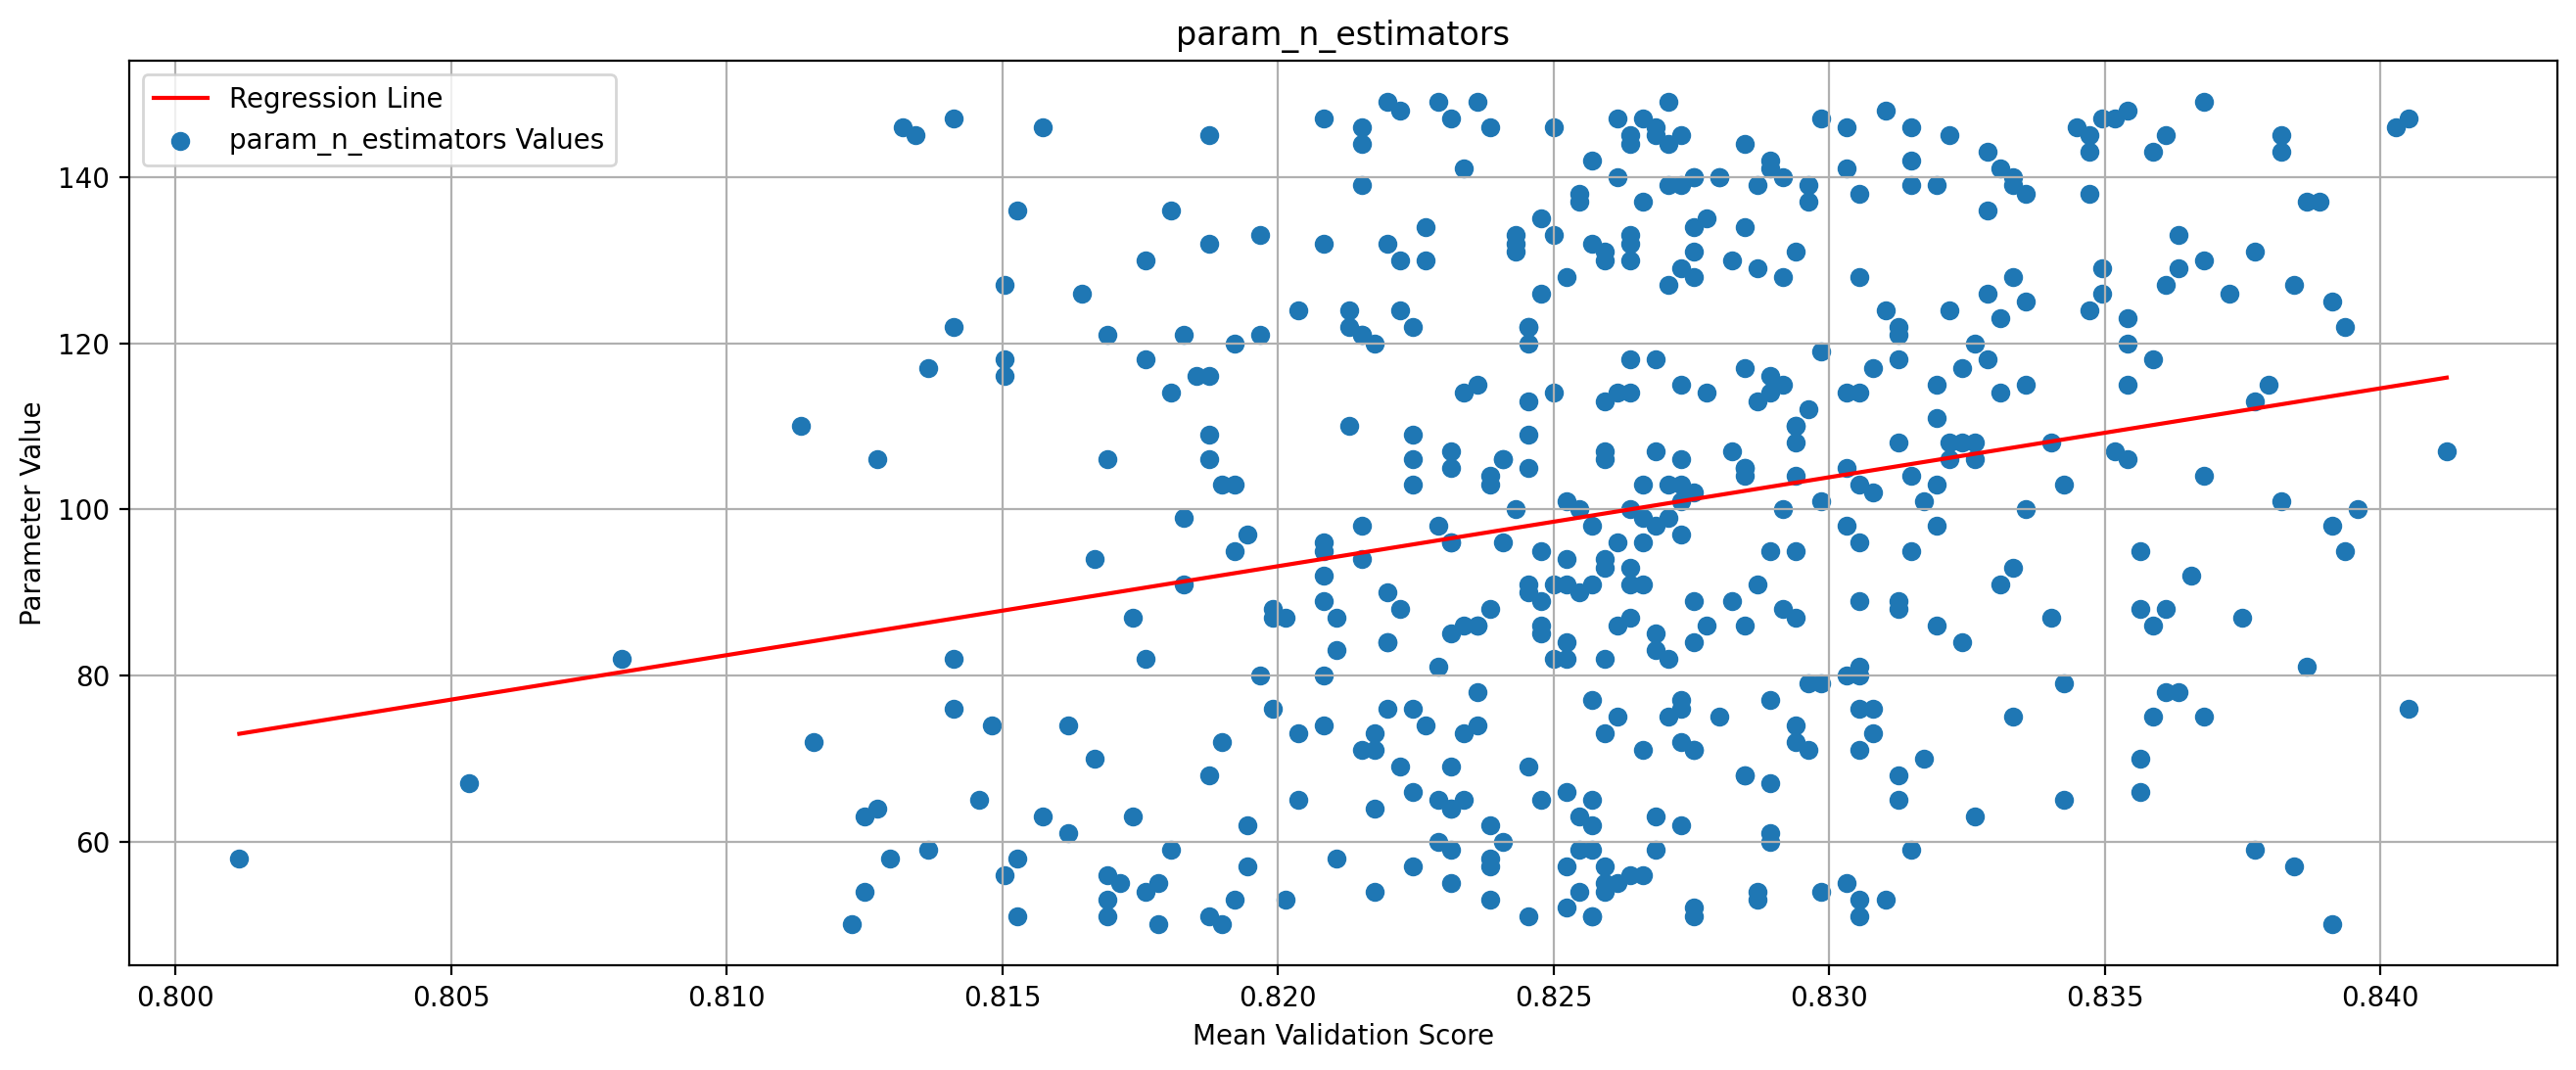

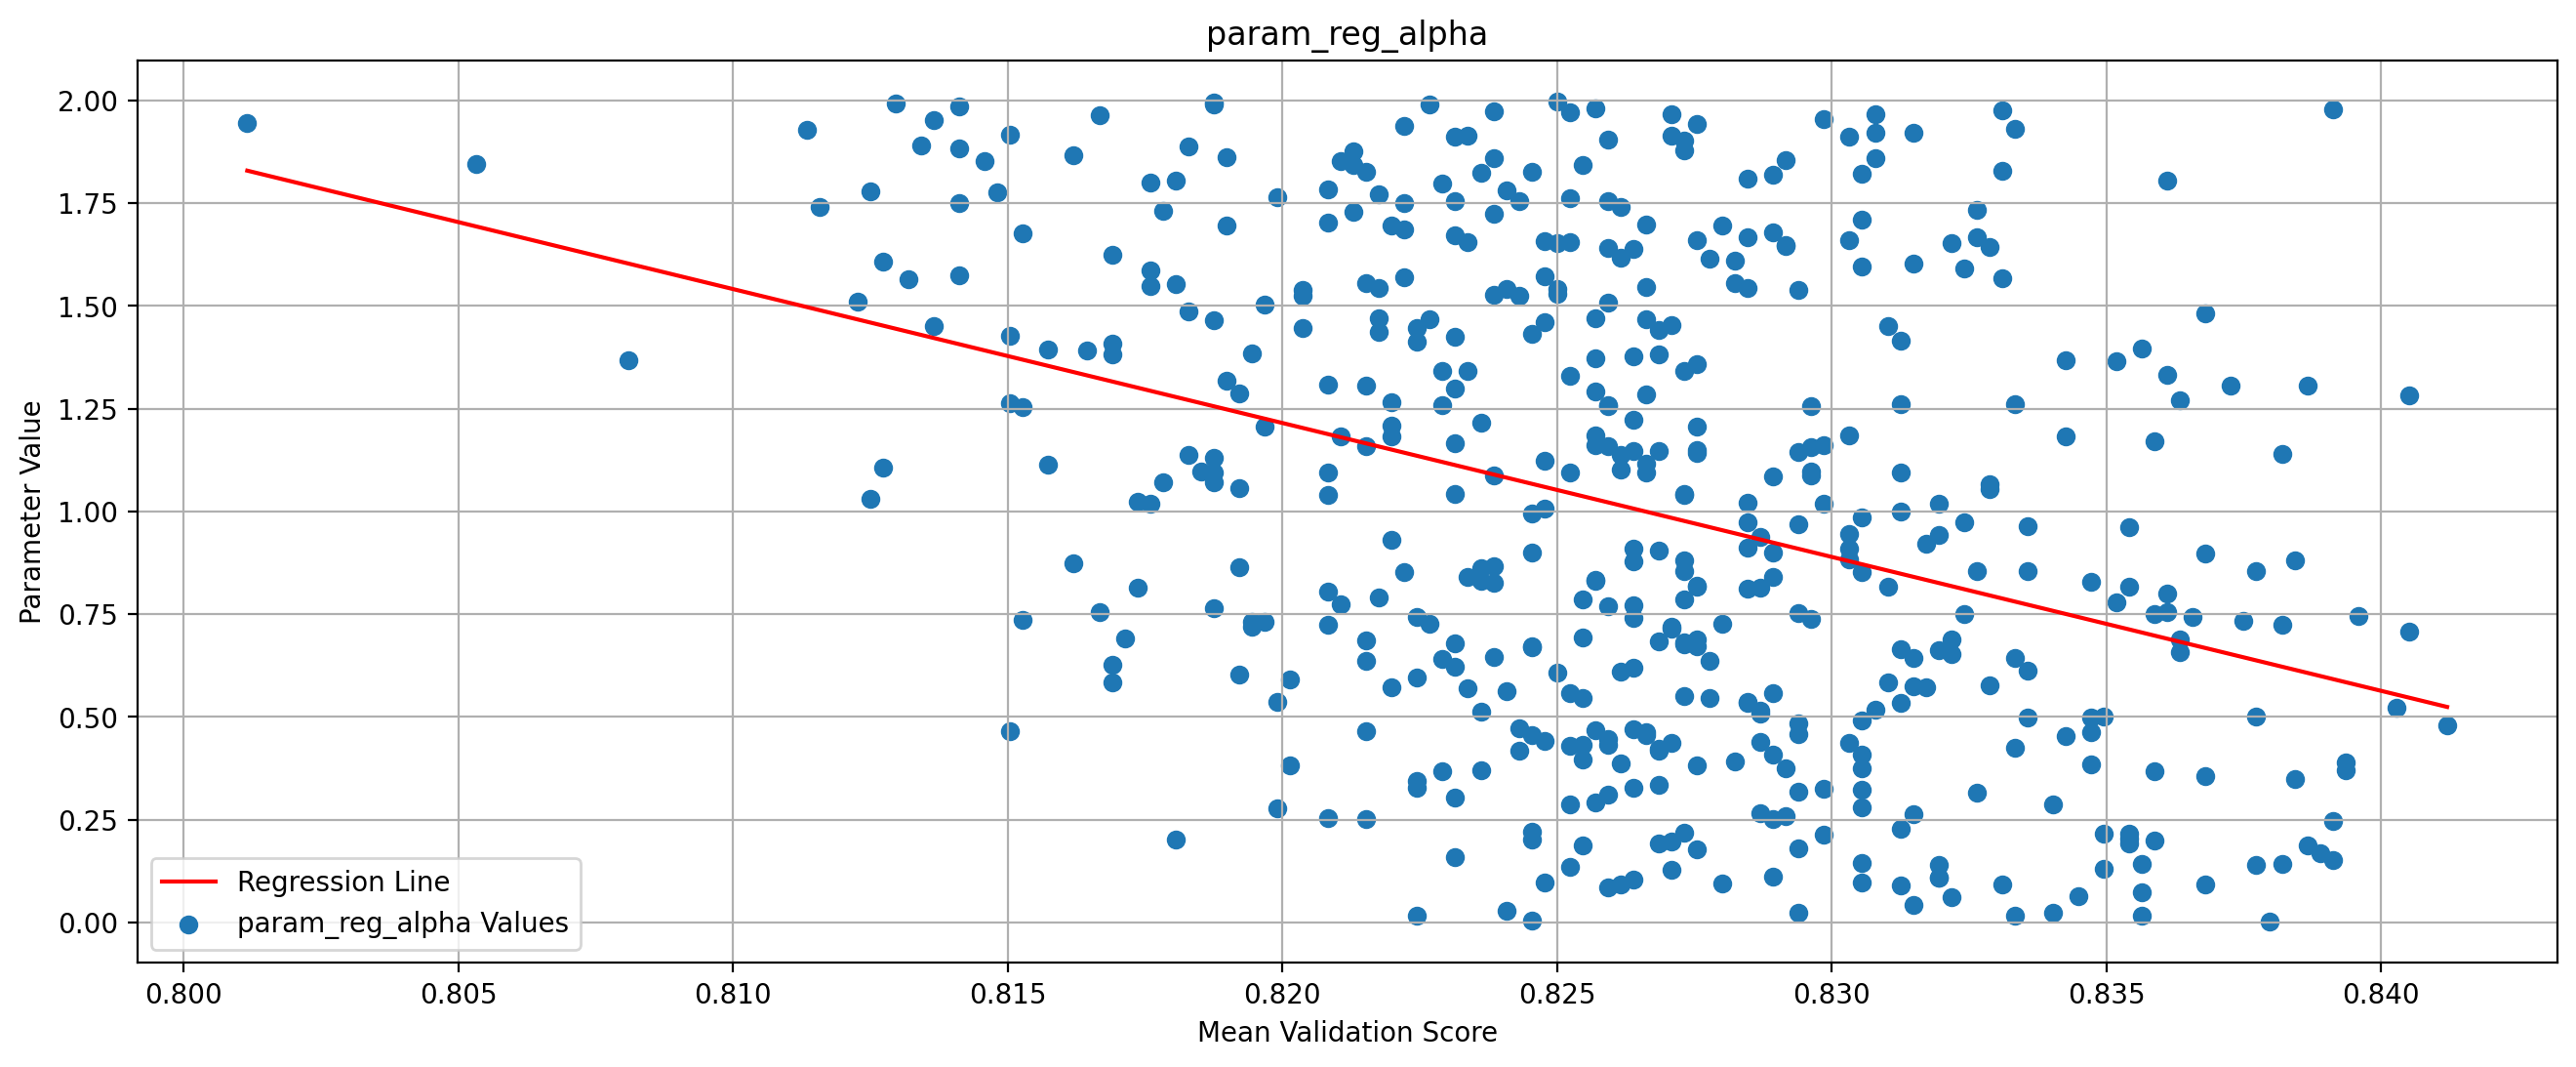

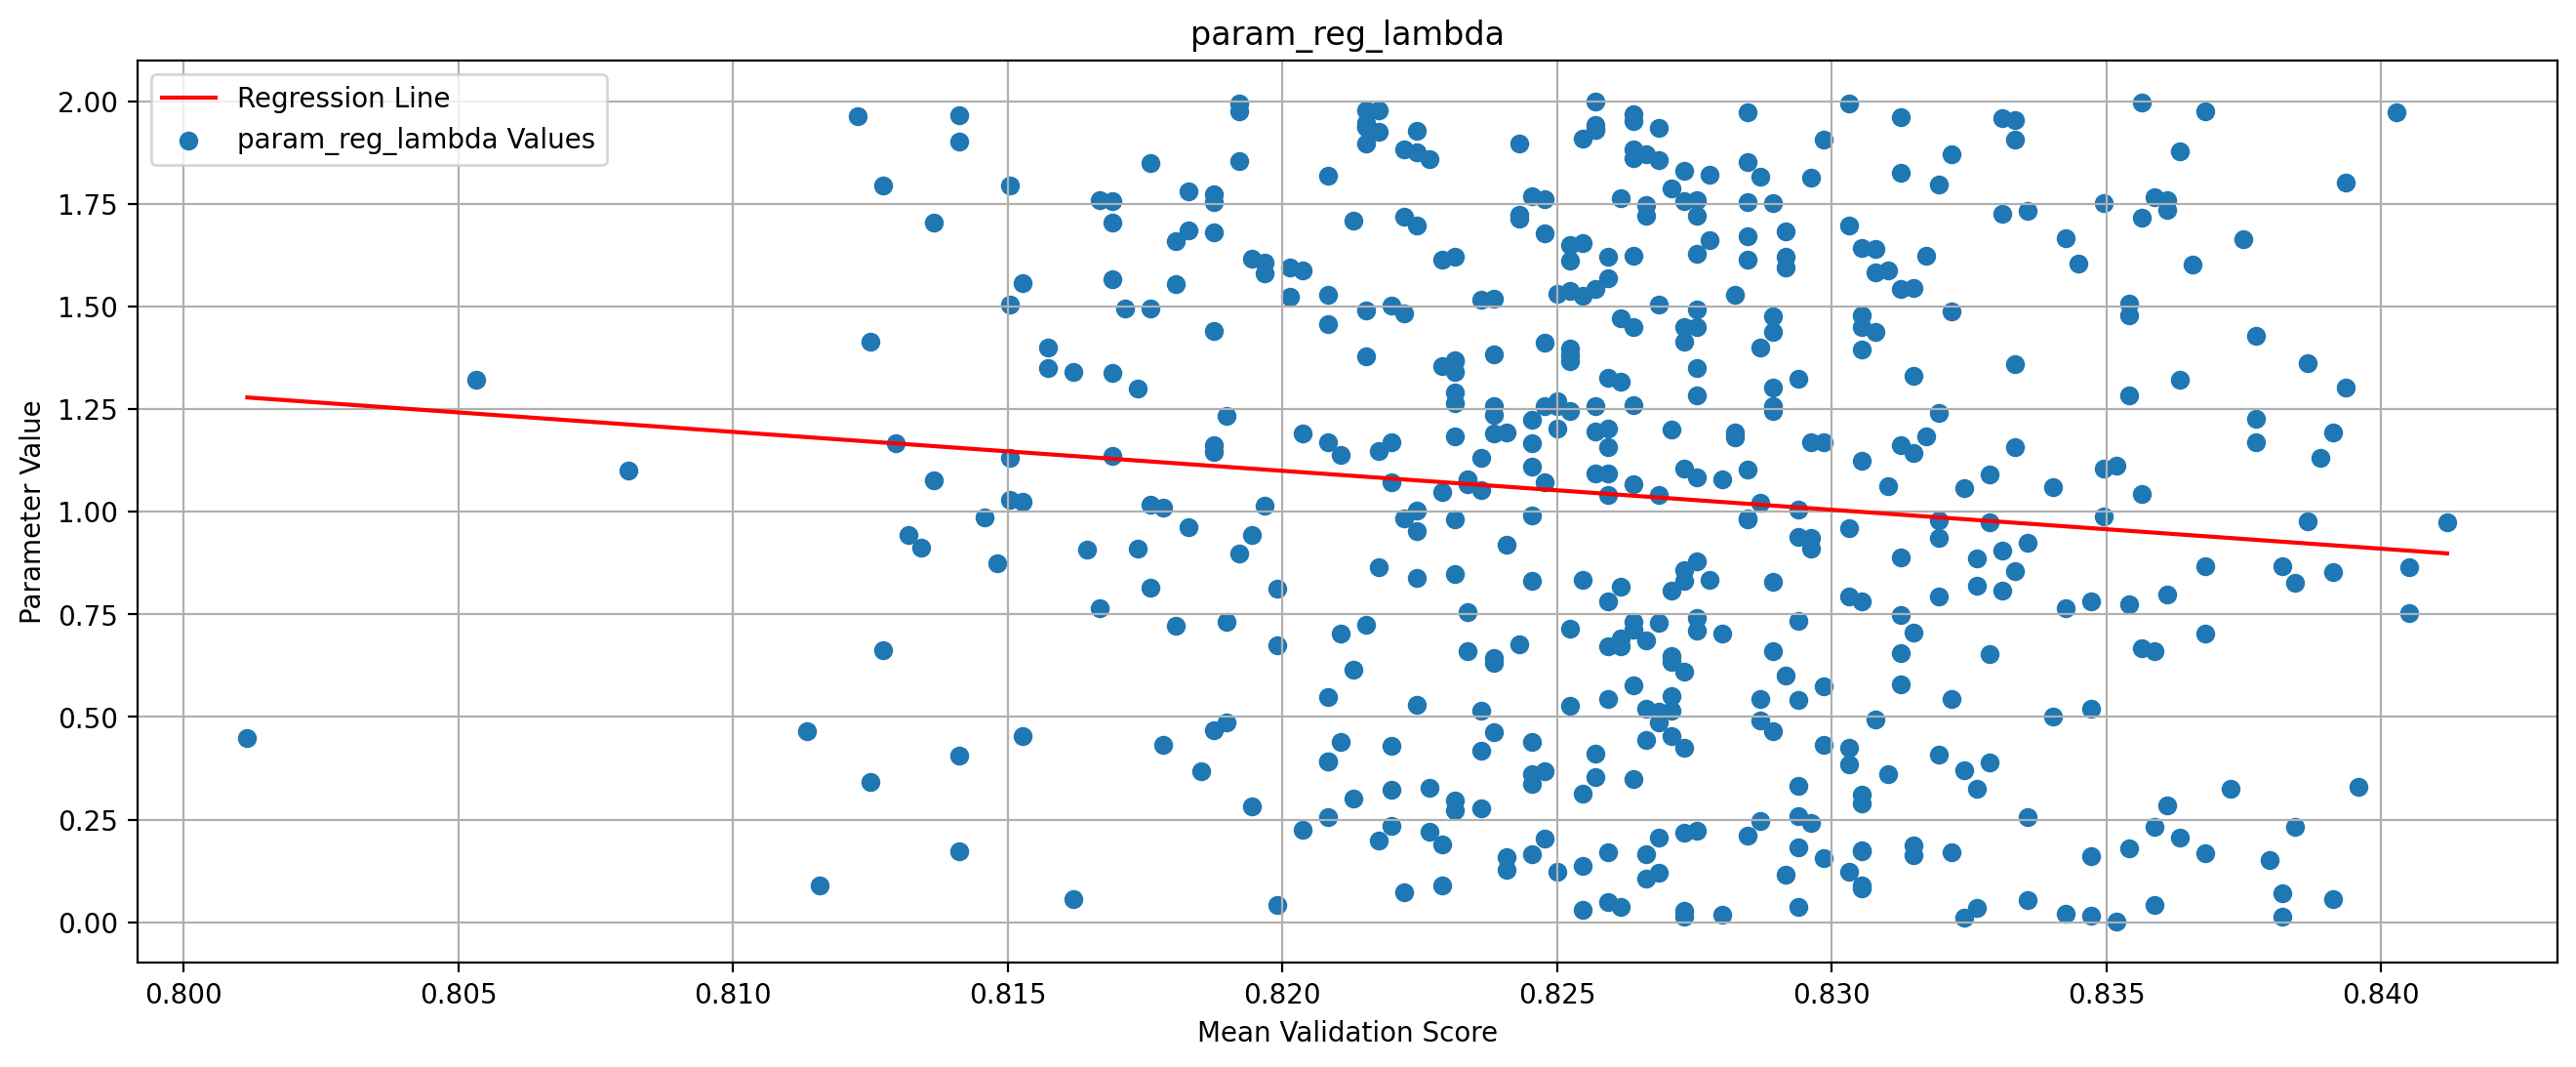

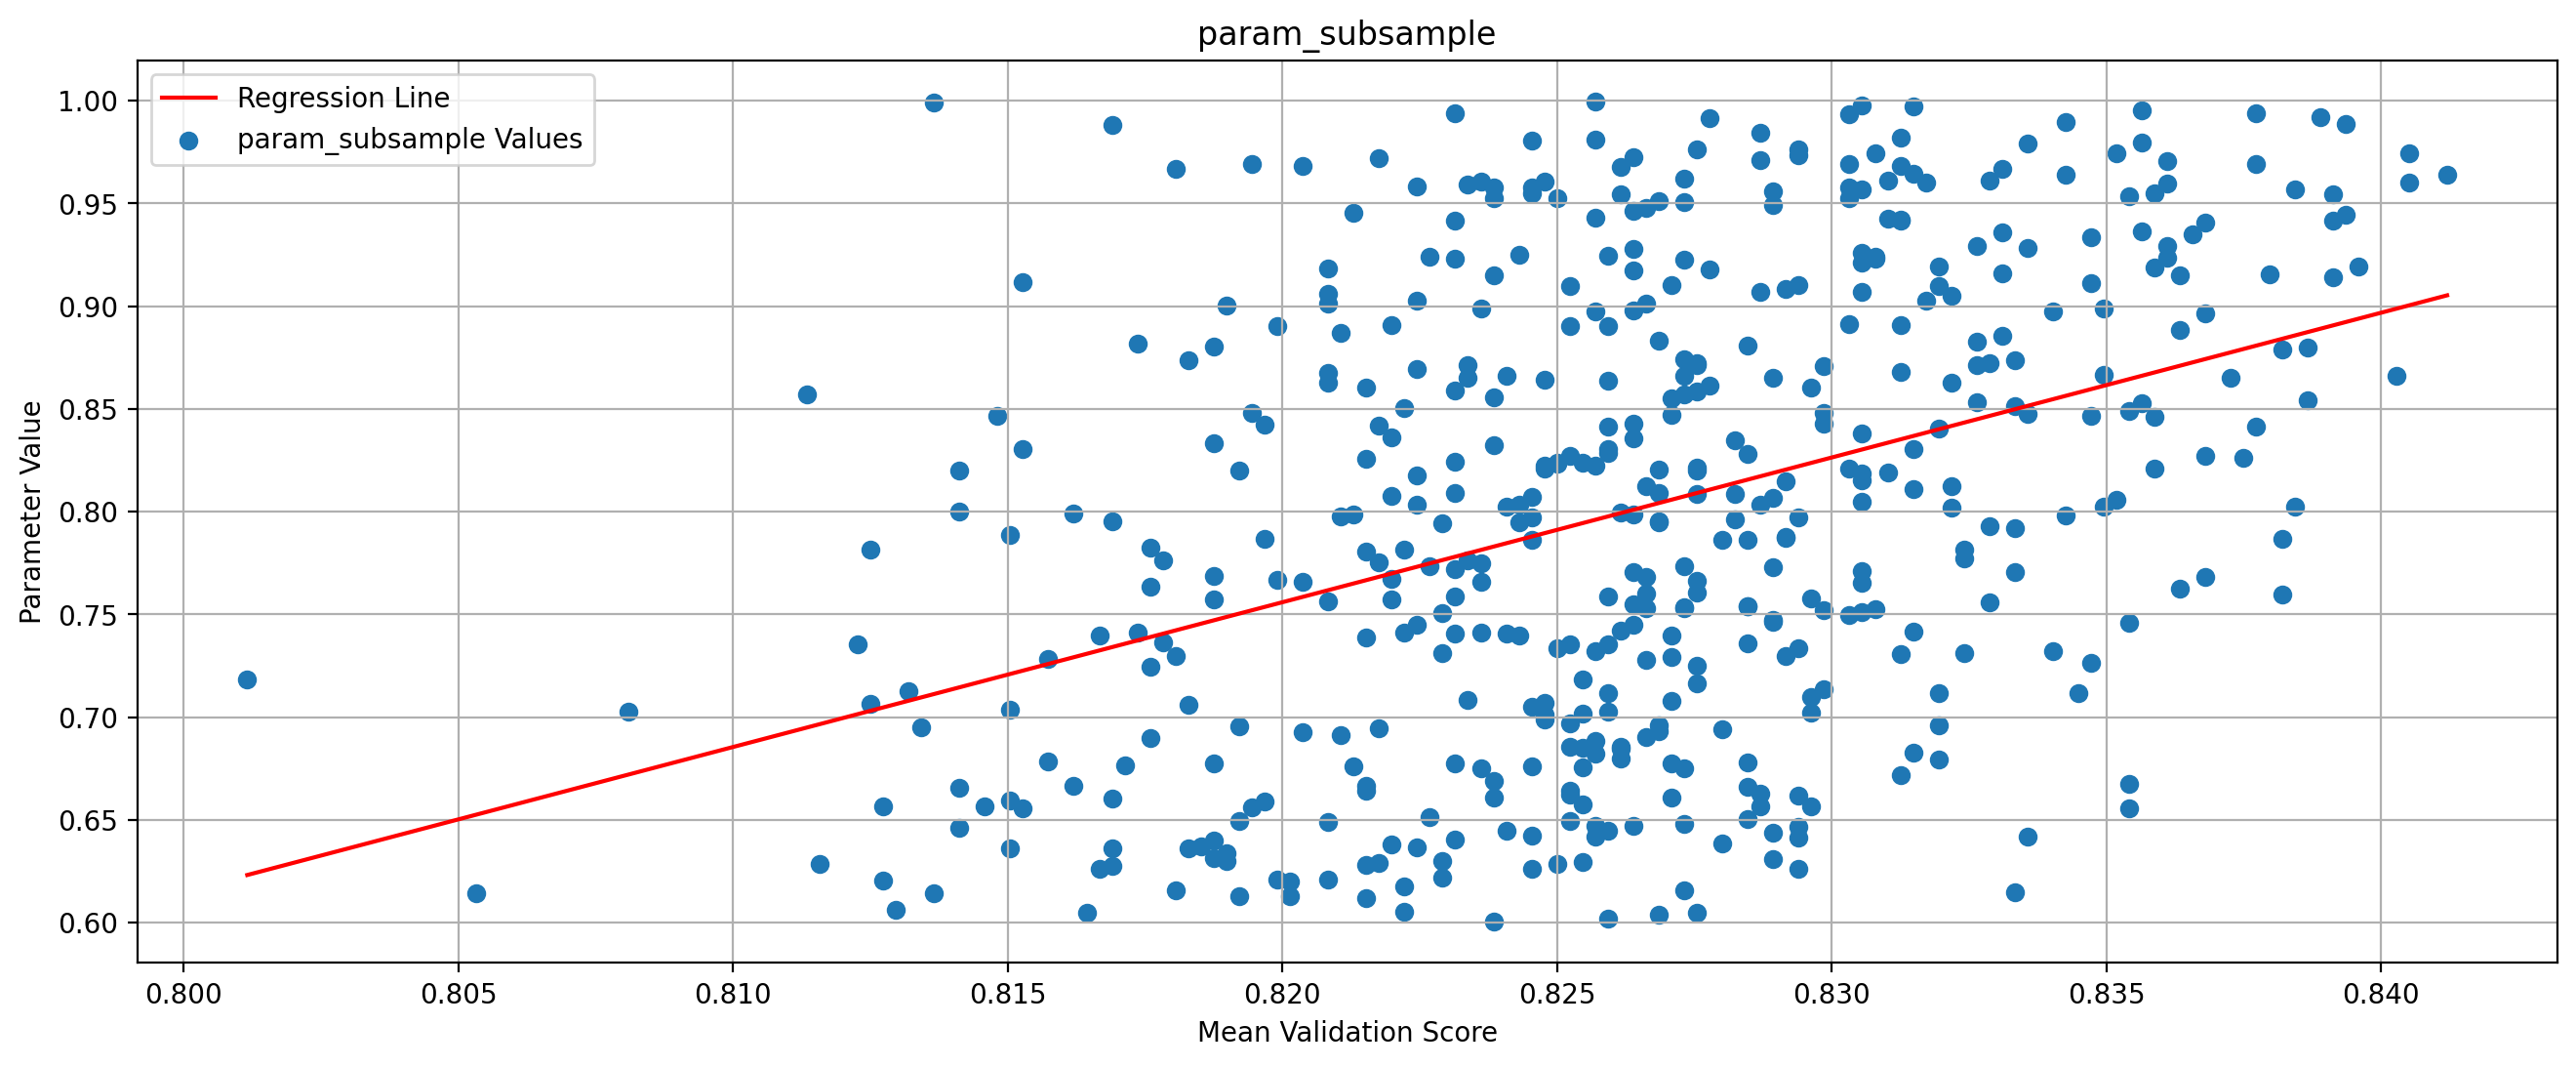

In [23]:
# TEST
for col in ['param_colsample_bylevel', 'param_colsample_bynode',
       'param_colsample_bytree', 'param_gamma', 'param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample']:
    
    plt.figure(figsize=(16, 6))    

    m, b = np.polyfit(list(sorted_cv['mean_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['mean_test_score'], m * sorted_cv['mean_test_score'] + b, c='r', label="Regression Line")
    plt.scatter(sorted_cv['mean_test_score'], sorted_cv[col], label=f"{col} Values")
    
    plt.grid()
    plt.xlabel('Mean Validation Score')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')

    
    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))
                  
    plt.show()


# Hyperparameter Evaluation

In [ ]:

def plot_parameters(x_values, title):
    
    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    #ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r', label='std_test_score')
    
    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)
    
    
    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))
            
    plt.show()



In [ ]:
for param in ['param_colsample_bylevel', 'param_colsample_bynode', 'param_colsample_bytree',
                     'param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 
                     'param_reg_alpha', 'param_reg_lambda', 'param_subsample']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


In [ ]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_train, classes=np.unique(y_train))
y_score_bin = label_binarize(y_train_prediction, classes=np.unique(y_train_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

classes = len(y_train.unique())

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))    
for i in range(classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))    
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')
            
filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Partial Dependence

In [ ]:
# potentially iterate over features (and relation ie 0 to 1)

In [ ]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence') 
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))
            
plt.show()


# Confusion Matrix

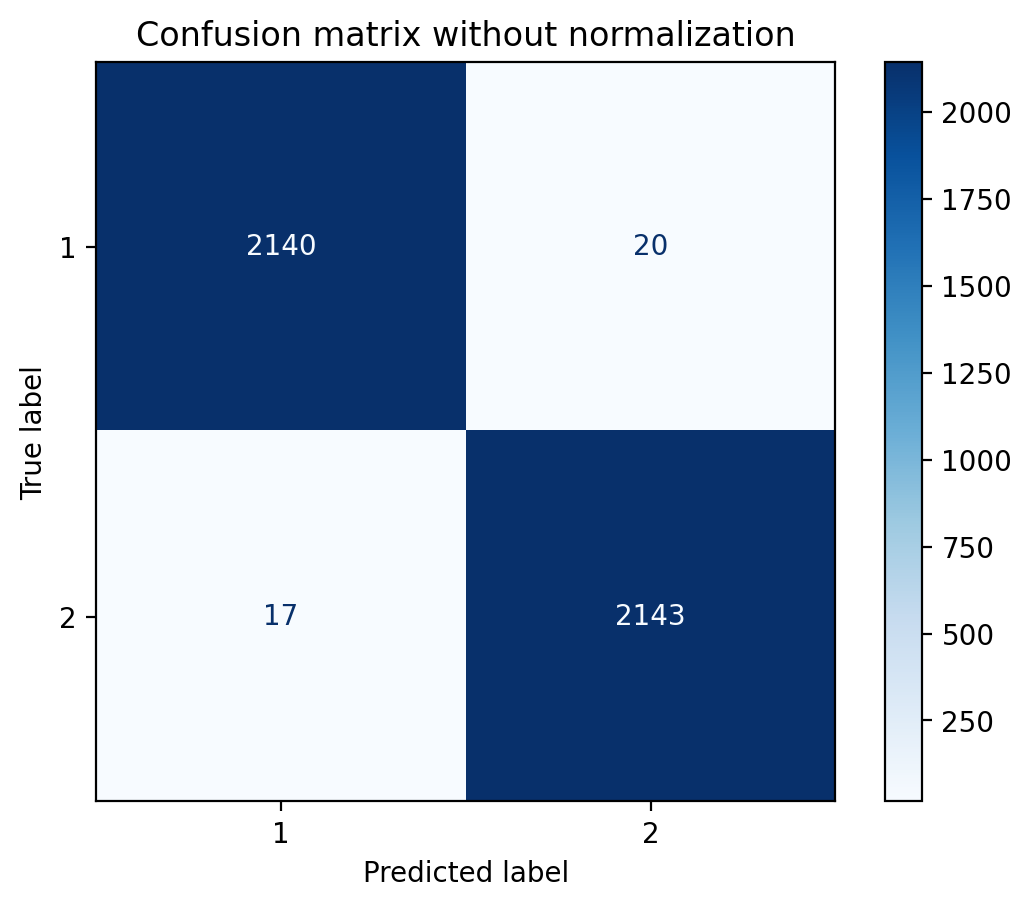

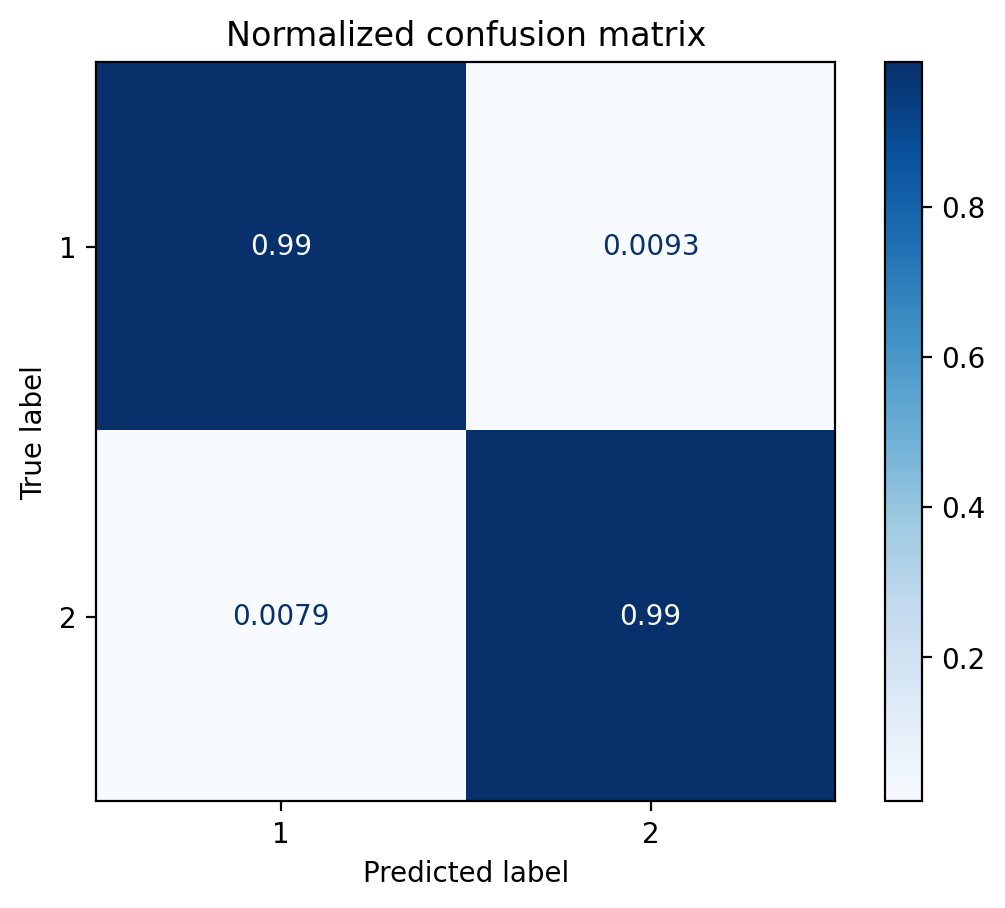

In [24]:

class_names = np.unique(y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_train,
        y_train,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_train, check_additivity=False)


In [ ]:
shap.summary_plot(explanation, X_train, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()  

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.


In [ ]:
# IF WE SCALE: SCALE ONLY TRAIN DATA SET
# BOOSTING ALG:

# - Feature Selection: AUTOMATIC (NON CRITICAL)
# - Scaling: AUTOMATIC
# - Handling Missing Values: AUTOMATIC
# - Outliers: NEED TO DEAL WITH

# XGB Model Selection

In [ ]:
from numpy import sort
thresholds = sort(model.feature_importances_)

In [ ]:
from sklearn.model_selection import cross_val_score

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier(**best_params)
    selection_model.fit(select_X_train, y_train)

    scores = cross_val_score(selection_model, select_X_train, y_train, cv=5)
    accuracy = np.mean(scores)

    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

# KAGGLE Prediction

In [ ]:
test_processed = pd.read_csv('Data/test_engineered.csv')

In [ ]:
test_processed.head()

In [ ]:
test_processed = test_processed.loc[:, [col for col in test_processed if not col.startswith('Cover_Type_')]]
X_kaggle = test_processed.drop(columns=['Aspect_Sector'])
y_kaggle = model.predict(X_kaggle) + 1

In [ ]:
pd.read_csv("Data/Kaggle/full_submission.csv").head()

In [ ]:
test_processed['Cover_Type'] = y_kaggle

In [ ]:
kaggle_submission = test_processed.loc[:, ['Id', 'Cover_Type']]

In [ ]:
kaggle_submission.Cover_Type.value_counts()

In [ ]:
kaggle_submission.to_csv(f'Data/kaggle_submission_{timestamp}.csv', index=False)

In [ ]:
pd.read_csv(f'Data/kaggle_submission_{timestamp}.csv')

In [ ]:
timestamp